**Table of contents**<a id='toc0_'></a>    
- [Initial Tests](#toc1_)    
- [Using minimize from scipy.optimize](#toc2_)    
- [Using PyTorch](#toc3_)    
  - [Forward Network](#toc3_1_)    
  - [Inverse Network](#toc3_2_)    
    - [Forward Network --> Inverse Network](#toc3_2_1_)    
    - [Inverse Network --> Forward Network](#toc3_2_2_)    
    - [Only Inverse Network](#toc3_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Initial Tests](#toc0_)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
from ofc_functions import *


π = np.pi
SpS = 64            # Samples per symbol 
Rs  = 10e9          # Symbol rate (baud rate - symbols per second)
Ts  = 1/Rs          # Symbol period (s)
Fa  = 1/(Ts/SpS)    # Sampling frequency of the signal (samples per second)
Ta  = 1/Fa          # Sampling period of the signal (s)
NFFT = 16*1024      # Number of points of the FFT 

t = np.arange(0, SpS*500)*Ta # Time vector for the signal (s)

Vπ = 2             # Voltage required to achieve a π phase shift (V)
P = 1              # Power of the signal (W)
n_peaks = 11       # Number of peaks to be found in the signal

# Parameters for the modulators cascaded
V_min = 0 # Minimum amplitude voltage (V)
V_max = 3 # Maximum amplitude voltage (V)
Phase_min = 0 # Minimum phase (rad)
Phase_max = 2*π # Maximum phase (rad) --> Phase is periodic with period 2*π
#Phase_max = 10*2*π # Maximum phase (rad) --> Phase is periodic with period 2*π
Vb_min = 0 # Minimum bias voltage (V)
Vb_max = 4*Vπ # Maximum bias voltage (V) --> Vb is periodic with period 4*Vπ
#Vb_max = 10*4*Vπ # Maximum bias voltage (V) --> Vb is periodic with period 4*Vπ


bounds = [(V_min,V_max),(V_min,V_max),(V_min,V_max), 
        (Phase_min, Phase_max),(Phase_min, Phase_max), (Phase_min, Phase_max),
        (Vb_min,Vb_max), (Vb_min,Vb_max)] # Bounds of the parameters


In [2]:
def frequencyCombPeaks(params):
    ''' 
    Function to get the peaks of the power spectrum of the frequency comb signal

    Parameters:
    params: list
        Parameters to generate the frequency comb signal

    Returns:
    peaks: list
        Peaks of the power spectrum of the frequency comb signal
    '''
    
    frequency_comb = frequencyCombGenerator_MZM_MZM_PM(params, Rs, t, P, Vπ) # Generate the frequency comb signal
    Pxx, _ = get_psd_ByFFT(frequency_comb, Fa, NFFT) # Get the power spectrum of the frequency comb signal
    log_Pxx = 10*np.log10(Pxx) # Convert the power spectrum to dB
    indx = get_indx_peaks(log_Pxx, NFFT/SpS, n_peaks) # Get the indexes of the peaks

    peaks = log_Pxx[indx].tolist() # Get the peaks of the power spectrum
    return peaks

In [3]:
def plot_signalPower_and_frequencyComb(V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2):
    
    params = V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2
    frequencyComb = frequencyCombGenerator_MZM_MZM_PM(params, Rs, t, P, Vπ)

    _, ax = plt.subplots(1,3,figsize = (15,3));
    ax[0].plot(t[:SpS*4]*1e9, abs(frequencyComb[:SpS*4])**2, label = "Optical Signal")
    ax[0].set_xlabel("Time (ns)")
    ax[0].set_ylabel("Power (W)")
    ax[0].set_xlim(0,4*Ts*1e9)
    ax[0].set_ylim(0,1)
    ax[0].legend(loc='upper right')
    ax[0].grid()
    
    Pxx, freqs = get_psd_ByFFT(frequencyComb, Fa, NFFT)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, NFFT/SpS, n_peaks)

    ax[1].plot(freqs, log_Pxx, label = "Optical Signal Spectrum")
    ax[1].plot(freqs[indx], log_Pxx[indx], 'o')
    ax[1].set_xlim(-20*Rs,20*Rs);
    ax[1].set_ylim(-200,-50);
    ax[1].legend(loc='lower right');
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate");
    ax[1].set_ylabel("Power (dB)");
    ax[1].grid()
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx])
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")

    ax[2].axis('off')
    ax[2].text(0, 0.7, "Mean: %.2f dB" %mean, fontsize=10)
    ax[2].text(0, 0.6, "Standard Deviation: %.2f dB" %np.sqrt(var), fontsize=10)
    ax[2].text(0, 0.4, "Variance: %.4f dB^2"%var, fontsize=12)
    ax[2].text(0, 0.3, "max - min: %.4f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])), fontsize=12)

    plt.tight_layout()

In [4]:
import ipywidgets as widgets

initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744+np.pi, 2.0000486, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987+np.pi, 0.8391744, 2.0000486, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987+np.pi, 0.8391744+np.pi, 2.0000486, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987, 0.8391744+np.pi, 2.0000486, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987+np.pi, 0.8391744, 2.0000486, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987+np.pi, 0.8391744+np.pi, 2.0000486, 2.0055982e-06]

initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486+2*Vπ, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744+np.pi, 2.0000486+2*Vπ, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987+np.pi, 0.8391744, 2.0000486+2*Vπ, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987+np.pi, 0.8391744+np.pi, 2.0000486+2*Vπ, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987, 0.8391744, 2.0000486+2*Vπ, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987, 0.8391744+np.pi, 2.0000486+2*Vπ, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987+np.pi, 0.8391744, 2.0000486+2*Vπ, 2.0055982e-06]
initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987+np.pi, 0.8391744+np.pi, 2.0000486+2*Vπ, 2.0055982e-06]

initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362+np.pi, 0.7501987+np.pi, 0.8391744+np.pi, 2.0000486+2*Vπ, 2.0055982e-06+2*Vπ]

V1 = widgets.FloatSlider(value=initial_values[0], min=V_min, max=V_max,step = 0.001, description = 'V1')
V2 = widgets.FloatSlider(value=initial_values[1], min=V_min, max=V_max,step = 0.001, description = 'V2')
V3 = widgets.FloatSlider(value=initial_values[2], min=V_min, max=V_max,step = 0.001, description = 'V3')
Phase1 = widgets.FloatSlider(value=initial_values[3], min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase1')
Phase2 = widgets.FloatSlider(value=initial_values[4], min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase2')
Phase3 = widgets.FloatSlider(value=initial_values[5], min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase3')
Vb1 = widgets.FloatSlider(value=initial_values[6], min=Vb_min, max=Vb_max,step = 0.001, description = 'Vb1')
Vb2 = widgets.FloatSlider(value=initial_values[7], min=Vb_min, max=Vb_max,step = 0.001, description = 'Vb2')

ui1 = widgets.HBox([V1, V2, V3, Vb1])
ui2 = widgets.HBox([Phase1, Phase2, Phase3, Vb2])
out1 = widgets.interactive_output(plot_signalPower_and_frequencyComb, {'V1': V1, 'V2': V2,'V3':V3,'Phase1':Phase1, 'Phase2':Phase2, 'Phase3':Phase3,'Vb1': Vb1, 'Vb2': Vb2})

display(ui1, ui2,out1)

Output()

# <a id='toc2_'></a>[Using minimize from scipy.optimize](#toc0_)

In [5]:
from scipy.optimize import minimize

# Função objetivo a ser minimizada
def objective_function(params):
    
    frequencyComb = frequencyCombGenerator_MZM_MZM_PM(params, Rs, t, P, Vπ)
    Pxx, _ = get_psd_ByFFT(frequencyComb, Fa, NFFT)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, NFFT/SpS, n_peaks)
    
    var = np.var(log_Pxx[indx])
    target_var = 0
    
    return (var - target_var)**2

In [6]:
#function to do the optimization def optimizated_flat_comb(initial_guess, n = 100, method = "SLSQP"):
def optimization_flatComb(initial_guess, n_max = 100, method = "SLSQP"):
    ''' 
    Function to optimize the parameters of the frequency comb signal

    Parameters:
    initial_guess: list
        Initial guess for the parameters of the frequency comb signal
    n: int
        Number of iterations
    method: string
        Optimization method

    Returns:
    optimized_params: list
        Optimized parameters of the frequency comb signal
    '''

    optimized_params = initial_guess
    n = 0
    while n < n_max:
        initial_guess = optimized_params
        result = minimize(objective_function, initial_guess, method=method,bounds = bounds)
        optimized_params = result.x
        
        peaks = frequencyCombPeaks(optimized_params)
        min_max = np.max(peaks) - np.min(peaks)

        if min_max < 1:
            break
        n += 1

    return optimized_params, peaks, min_max

In [78]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [1.5, 1.5, 1.5, np.pi, np.pi, np.pi, 2*Vπ, 2*Vπ]

optimized_params,_, _ = optimization_flatComb(initial_guess)
V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.4f} V")
print(f"V2: {V2:.4f} V")
print(f"V3: {V3:.4f} V")
print(f"Phase1: {Phase1:.4f} rad")
print(f"Phase2: {Phase2:.4f} rad")
print(f"Phase3: {Phase3:.4f} rad")
print(f"Vb1: {Vb1:.4f} V")
print(f"Vb2: {Vb2:.4f} V")

Configurações otimizadas:
V1: 2.8430 V
V2: 2.5604 V
V3: 2.8924 V
Phase1: 3.6396 rad
Phase2: 3.0298 rad
Phase3: 4.4361 rad
Vb1: 3.9993 V
Vb2: 3.9998 V


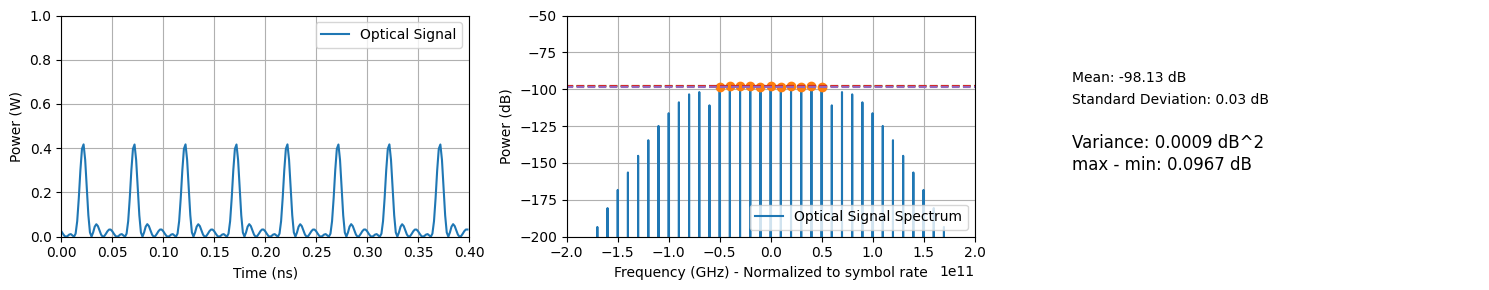

In [79]:
plot_signalPower_and_frequencyComb(*optimized_params)

# <a id='toc3_'></a>[Using PyTorch](#toc0_)

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [8]:
class FrequencyCombNet(nn.Module):
    def __init__(self, architecture):
        self.architecture = architecture
        super(FrequencyCombNet, self).__init__()
        layers = [nn.Linear(architecture[0], architecture[1])]
        for i in range(1, len(architecture) - 1):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(architecture[i], architecture[i + 1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [9]:

# Define your custom dataset
class FrequencyCombDataset(Dataset):
    def __init__(self, function, nsamples, bounds, norm_scale = 1):
        self.function = function
        self.nsamples = nsamples
        self.bounds = bounds
        self.norm_scale = norm_scale
        
        inputs = self.make_inputs(self.bounds, self.nsamples)
        self.input_tensors = torch.from_numpy(np.array(inputs)).float()

        outputs = self.make_outputs(inputs, self.function)
        self.output_tensors = torch.from_numpy(np.array(outputs)).float()
        if norm_scale == 1:
            self.norm_scale = torch.ceil(torch.max(torch.abs(self.output_tensors))).item()
        self.output_tensors = self.normalize(self.output_tensors)
    
    def make_inputs(self, bounds, nsamples):
        inputs = [[urand.Uniform(low, high).sample().item() for low, high in bounds] for _ in range(nsamples)]
        return inputs

    def make_outputs(self, inputs, function, zero_mean = True):
        outputs = []
        for input in inputs:
            freq_peaks = function(input)
            freq_peaks = freq_peaks - np.mean(freq_peaks)*zero_mean
            outputs.append(freq_peaks)
        return outputs

    def __len__(self):
        return len(self.input_tensors)
    
    def data_size(self):
        inputs_size_in_bytes = self.input_tensors.nelement() * self.input_tensors.element_size()/1024
        outputs_size_in_bytes = self.output_tensors.nelement() * self.output_tensors.element_size()/1024
        return inputs_size_in_bytes + outputs_size_in_bytes
    
    def normalize(self, tensor):
        norm_tensor = (tensor + self.norm_scale) / (2* self.norm_scale)
        return norm_tensor
    
    def denormalize(self, tensor):
        denorm_tensor = tensor * 2* self.norm_scale - self.norm_scale
        return denorm_tensor
    
    def __getitem__(self, idx):
        return self.input_tensors[idx], self.output_tensors[idx]

In [66]:
train_nsamples = 300000             # Number of samples for training   (80%)
val_nspamples  = train_nsamples//8  # Number of samples for validation (10%)
test_nsamples  = train_nsamples//8  # Number of samples for testing    (10%)

train_nsamples = 300000             # Number of samples for training   (80%)
val_nspamples  = 30000  # Number of samples for validation (10%)
test_nsamples  = 30000

#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device}")

Runnning in cuda


In [67]:
#load datasets if they exist, create them otherwise

dataset_name = f"mzm_mzm_pm_{train_nsamples*1e-3:.0f}k_samples"
train_filename = "saved_data/datasets/train_dataset_" + dataset_name + ".pt"
test_filename = "saved_data/datasets/test_dataset_" + dataset_name + ".pt"
val_filename = "saved_data/datasets/val_dataset_" + dataset_name + ".pt"
if os.path.exists(train_filename) and os.path.exists(test_filename) and os.path.exists(val_filename):
    print("Loading datasets...")
    train_dataset = torch.load(train_filename)
    test_dataset = torch.load(test_filename)
    val_dataset = torch.load(val_filename)
    print("Datasets loaded!")
else:
    print("Creating datasets...")
    train_dataset = FrequencyCombDataset(frequencyCombPeaks, train_nsamples, bounds)
    test_dataset  = FrequencyCombDataset(frequencyCombPeaks, test_nsamples,  bounds, train_dataset.norm_scale)
    val_dataset   = FrequencyCombDataset(frequencyCombPeaks, val_nspamples,  bounds, train_dataset.norm_scale)
    print("Datasets created!")

    torch.save(train_dataset, train_filename)
    torch.save(test_dataset, test_filename)
    torch.save(val_dataset, val_filename)
    print("Datasets saved!")


Loading datasets...
Datasets loaded!


In [ ]:
inputs = FrequencyCombDataset.make_inputs(FrequencyCombDataset,bounds = bounds, nsamples = 10000)

flatComb_inputs0_1dB = []
flatComb_outputs0_1dB = []

flatComb_inputs1_5dB = []
flatComb_outputs1_5dB = []
for input in inputs:
    best_params, peaks, min_max = optimization_flatComb(input, n_max = 5)
    if min_max < 1:
        flatComb_inputs0_1dB.append(best_params)
        peaks = peaks - np.mean(peaks)
        flatComb_outputs0_1dB.append(peaks)
    elif min_max < 5:
        flatComb_inputs1_5dB.append(best_params)
        peaks = peaks - np.mean(peaks)
        flatComb_outputs1_5dB.append(peaks)

#suffle the data
idx = np.random.permutation(len(flatComb_inputs0_1dB))
flatComb_inputs0_1dB = np.array(flatComb_inputs0_1dB)[idx]
flatComb_outputs0_1dB = np.array(flatComb_outputs0_1dB)[idx]

idx = np.random.permutation(len(flatComb_inputs1_5dB))
flatComb_inputs1_5dB = np.array(flatComb_inputs1_5dB)[idx]
flatComb_outputs1_5dB = np.array(flatComb_outputs1_5dB)[idx]

#save flatComb_inputs and flatComb_outputs using numpy
np.save(f"flatComb_inputs0_1dB_{len(flatComb_inputs0_1dB)}.npy", flatComb_inputs0_1dB)
np.save(f"flatComb_outputs0_1dB_{len(flatComb_outputs0_1dB)}.npy", flatComb_outputs0_1dB)

np.save(f"flatComb_inputs1_5dB_{len(flatComb_inputs1_5dB)}.npy", flatComb_inputs1_5dB)
np.save(f"flatComb_outputs1_5dB_{len(flatComb_outputs1_5dB)}.npy", flatComb_outputs1_5dB)

In [12]:
# load flatComb_inputs and flatComb_outputs using numpy
flatComb_inputs0_1dB = np.load("flatComb_inputs0_1dB_4810.npy")
flatComb_outputs0_1dB = np.load("flatComb_outputs0_1dB_4810.npy")

flatComb_inputs1_5dB = np.load("flatComb_inputs1_5dB_4810.npy")
flatComb_outputs1_5dB = np.load("flatComb_outputs1_5dB_4810.npy")

In [13]:
#normalization
flatComb_outputs0_1dB = train_dataset.normalize(flatComb_outputs0_1dB)
flatComb_outputs1_5dB = train_dataset.normalize(flatComb_outputs1_5dB)

#concatenate the data
flatComb_inputs = np.concatenate((flatComb_inputs0_1dB, flatComb_inputs1_5dB))
flatComb_outputs = np.concatenate((flatComb_outputs0_1dB, flatComb_outputs1_5dB))

#shuffle the data
idx = np.random.permutation(len(flatComb_inputs))
flatComb_inputs = flatComb_inputs[idx]
flatComb_outputs = flatComb_outputs[idx]

#split the flatComb data into train, test and validation
train_flatComb = 0.8
val_flatComb = 0.1
test_flatComb = 0.1

# indexes for the split: combs 0-1dB
train_flatComb_idx = int(train_flatComb*len(flatComb_inputs))
val_flatComb_idx = int((train_flatComb + val_flatComb)*len(flatComb_inputs))
test_flatComb_idx = int((train_flatComb + val_flatComb + test_flatComb)*len(flatComb_inputs))

# train 
train_flatComb_inputs = flatComb_inputs[:train_flatComb_idx]
train_flatComb_outputs = flatComb_outputs[:train_flatComb_idx]

# validation
val_flatComb_inputs = flatComb_inputs[train_flatComb_idx:val_flatComb_idx]
val_flatComb_outputs = flatComb_outputs[train_flatComb_idx:val_flatComb_idx]

# test
test_flatComb_inputs = flatComb_inputs[val_flatComb_idx:test_flatComb_idx]
test_flatComb_outputs = flatComb_outputs[val_flatComb_idx:test_flatComb_idx]

In [14]:
#add this flatCombs (0-1dB), and combs 1-5dB data to the big datasets

train_dataset.input_tensors = torch.cat((train_dataset.input_tensors, torch.from_numpy(train_flatComb_inputs).float()))
train_dataset.output_tensors = torch.cat((train_dataset.output_tensors, torch.from_numpy(train_flatComb_outputs).float()))

val_dataset.input_tensors = torch.cat((val_dataset.input_tensors, torch.from_numpy(val_flatComb_inputs).float()))
val_dataset.output_tensors = torch.cat((val_dataset.output_tensors, torch.from_numpy(val_flatComb_outputs).float()))

test_dataset.input_tensors = torch.cat((test_dataset.input_tensors, torch.from_numpy(test_flatComb_inputs).float()))
test_dataset.output_tensors = torch.cat((test_dataset.output_tensors, torch.from_numpy(test_flatComb_outputs).float()))

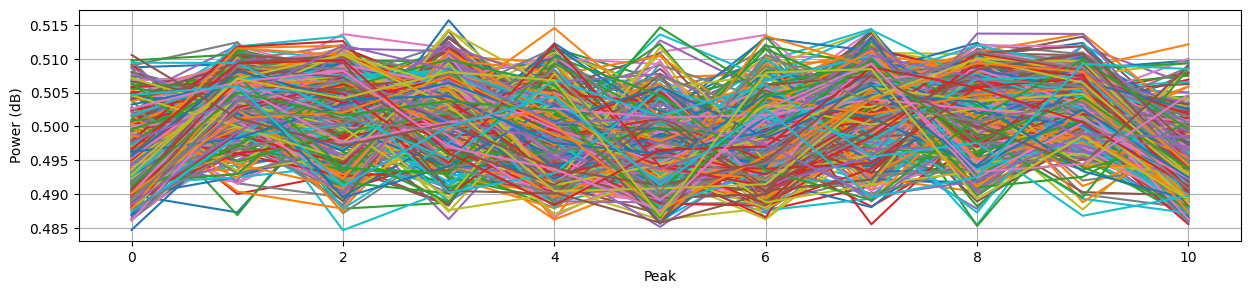

In [74]:
# plotting the all the outputs of the traindataset in the same plot
_, ax = plt.subplots(1,1,figsize = (15,3));
count1=0
count2=0
count3=0
count4=0
count5=0
for i in range(len(train_dataset.output_tensors)):
    min_max = np.max(train_dataset.denormalize(train_dataset.output_tensors[i]).numpy()) - np.min(train_dataset.denormalize(train_dataset.output_tensors[i]).numpy())
    if min_max < 1:
        ax.plot(train_dataset.output_tensors[i].numpy(), label = f"Sample {i}")
        count1+=1
    elif min_max < 2:
        count2+=1
    elif min_max < 3:
        count3+=1
    elif min_max < 4:
        count4+=1
    elif min_max < 5:
        count5+=1
ax.set_xlabel("Peak")
ax.set_ylabel("Power (dB)")
ax.grid()


In [75]:
count1, count2, count3, count4, count5

390

In [69]:
print(f"Porcentagem do dataset que é flat comb: {count1/len(train_dataset.output_tensors)*100:.2f}%")

Porcentagem do dataset que é flat: 0.00%


In [15]:
# Create data loaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

In [38]:
# Initialize the model
n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]
architecture = [n_inputs, 256, 512, 512, 256, 256, n_outputs]

model = FrequencyCombNet(architecture).to(device)
model_name = "model_" + "_".join([f"{n:.0f}" for n in architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"
model_path = "saved_data/models/"+ model_name +".pth"

# load model
if os.path.exists(model_path):
    print("Loading model...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print("Model loaded!")
else:
    print("No model found!")
    print("Model created!")

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # lr - learning rate

Loading model...
Model loaded!


In [17]:
def convert_to_real_loss(loss):
    loss = np.array(loss)
    loss = loss * (2 * train_dataset.norm_scale)**2
    return loss.squeeze()

In [18]:
def plot_training_progress(train_losses, val_losses, title = "Training and Validation Losses", ylabel = "Loss", average_curves = False, M = 200):

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    plt.figure(figsize=(15,5))
    plt.plot(train_losses, label=f'Training Loss: {train_losses[-1]:.4f}', color = "C0")
    plt.plot(val_losses, label=f'Validation Loss: {val_losses[-1]:.4f}', color='C3')

    if train_losses.size > M and average_curves:
        def moving_average(x, w):
            return np.convolve(x, np.ones(w), 'valid')/w
        plt.plot(moving_average(train_losses, M), color='blue', label='Training Loss (Moving Average)')
        plt.plot(moving_average(val_losses, M), color='red', label='Validation Loss (Moving Average)')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(which='both', alpha=0.5)
    plt.minorticks_on()
    plt.show()

In [19]:
# Training loop

## losses

train_losses_path = "saved_data/losses/" + model_name + '_train_losses.npy'
val_losses_path = "saved_data/losses/" + model_name + '_val_losses.npy'

# Load training losses if file exists
if os.path.exists(train_losses_path) and os.path.exists(val_losses_path):
    train_losses = list(np.load(train_losses_path))
    val_losses = list(np.load(val_losses_path))
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

Losses files not found.
Losses files created!


## <a id='toc3_1_'></a>[Forward Network](#toc0_)

Validation loss decreased (0.000072 --> 0.000071). Epoch: 5. Saving model...
Validation loss decreased (0.000071 --> 0.000071). Epoch: 14. Saving model...
Validation loss decreased (0.000071 --> 0.000071). Epoch: 15. Saving model...
Validation loss decreased (0.000071 --> 0.000071). Epoch: 19. Saving model...
Validation loss decreased (0.000071 --> 0.000070). Epoch: 21. Saving model...
Validation loss decreased (0.000070 --> 0.000069). Epoch: 32. Saving model...
Validation loss decreased (0.000069 --> 0.000069). Epoch: 38. Saving model...
Validation loss decreased (0.000069 --> 0.000069). Epoch: 49. Saving model...
Validation loss decreased (0.000069 --> 0.000068). Epoch: 50. Saving model...
Validation loss decreased (0.000068 --> 0.000068). Epoch: 63. Saving model...
Validation loss decreased (0.000068 --> 0.000068). Epoch: 72. Saving model...
Validation loss decreased (0.000068 --> 0.000068). Epoch: 75. Saving model...
Validation loss decreased (0.000068 --> 0.000067). Epoch: 79. Sav

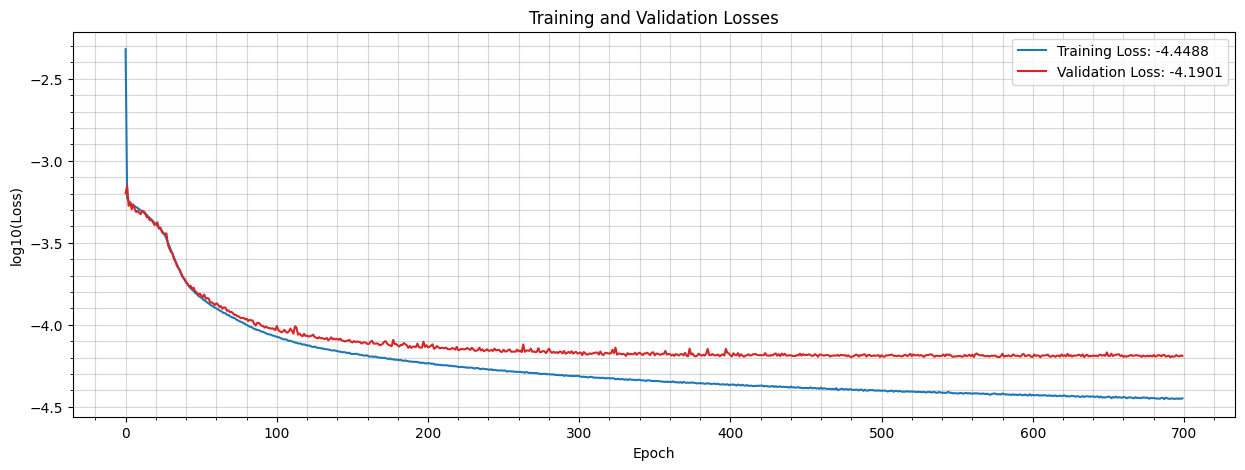

Validation loss decreased (0.000063 --> 0.000063). Epoch: 541. Saving model...
Validation loss decreased (0.000063 --> 0.000063). Epoch: 643. Saving model...
Validation loss decreased (0.000063 --> 0.000063). Epoch: 651. Saving model...
Epoch: 1000/5000.. Training loss: 1.359473 (dB/Hz)^2.. Validation Loss: 3.026950 (dB/Hz)^2


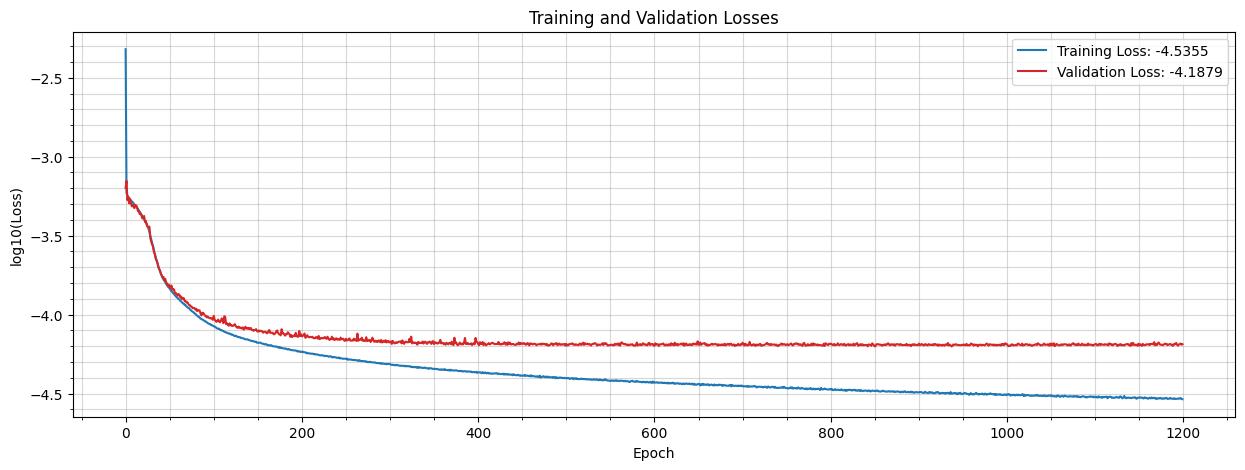

Epoch: 1500/5000.. Training loss: 1.224226 (dB/Hz)^2.. Validation Loss: 3.038992 (dB/Hz)^2


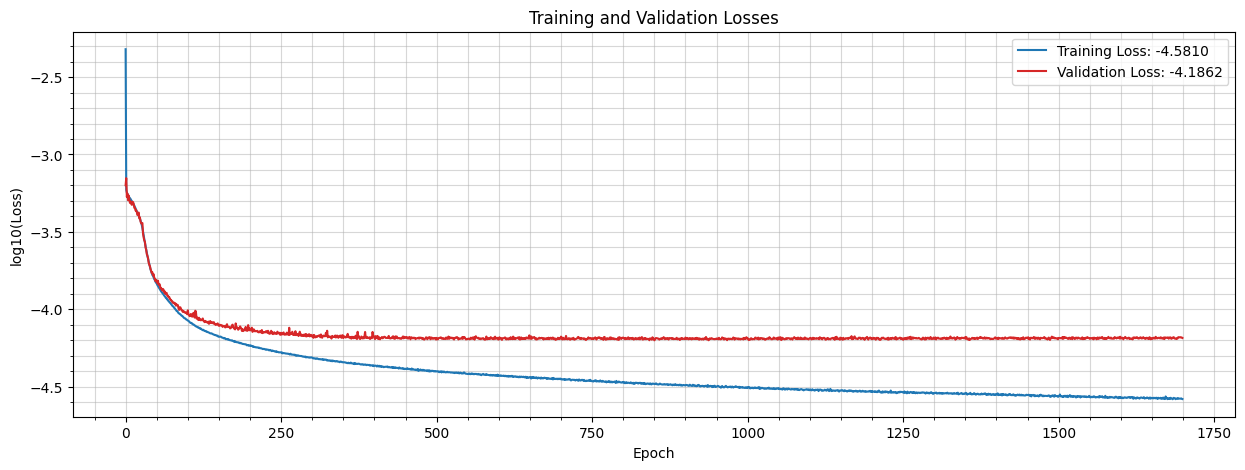

Epoch: 2000/5000.. Training loss: 1.130439 (dB/Hz)^2.. Validation Loss: 3.064758 (dB/Hz)^2


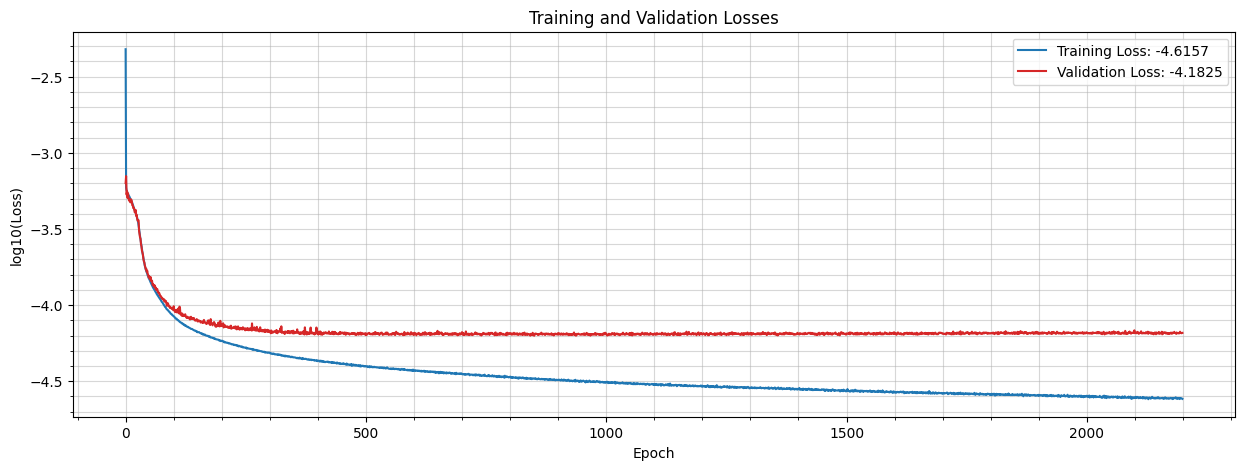

Epoch: 2500/5000.. Training loss: 1.073886 (dB/Hz)^2.. Validation Loss: 3.072024 (dB/Hz)^2


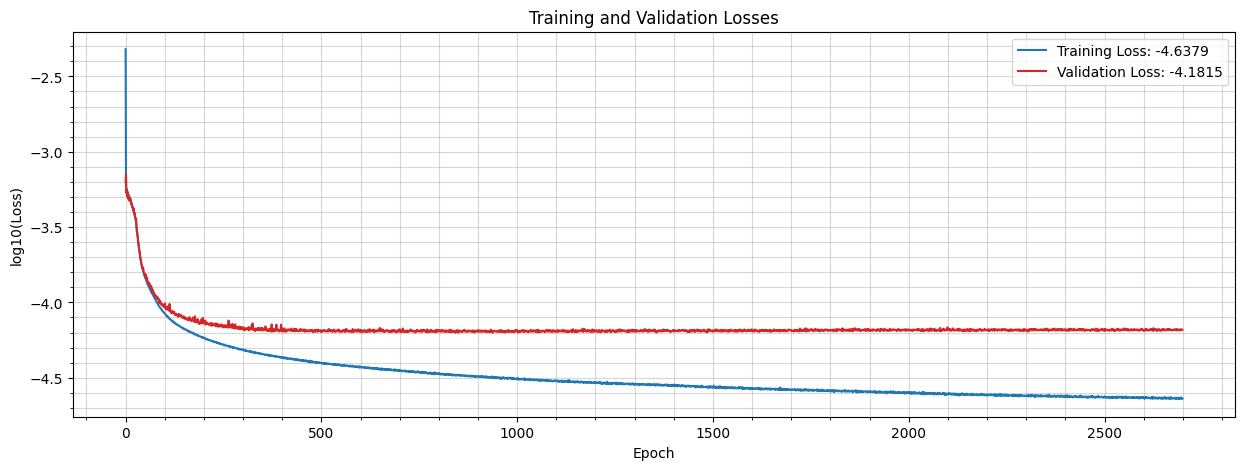

Epoch: 3000/5000.. Training loss: 1.026648 (dB/Hz)^2.. Validation Loss: 3.080569 (dB/Hz)^2


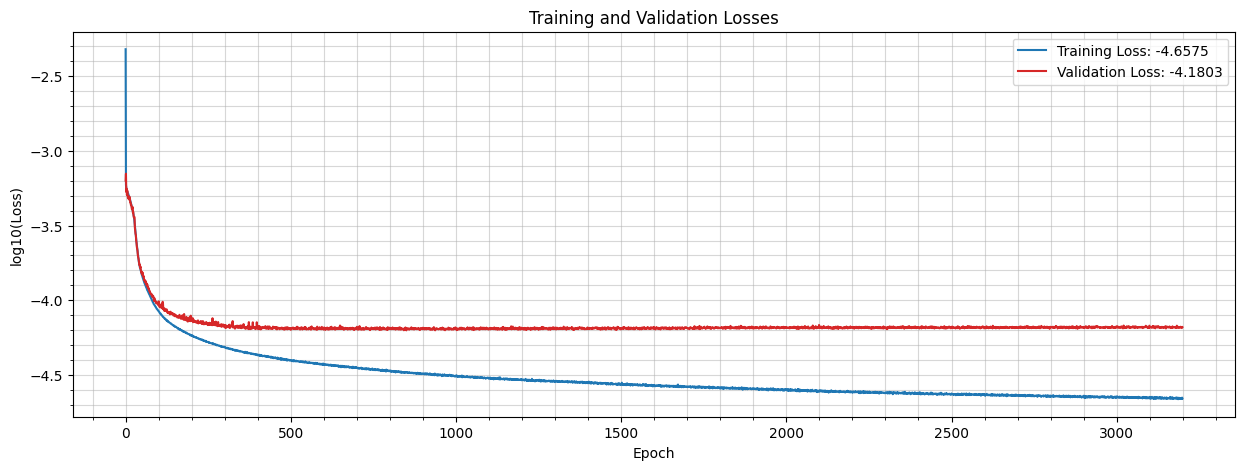

Epoch: 3500/5000.. Training loss: 0.985315 (dB/Hz)^2.. Validation Loss: 3.040984 (dB/Hz)^2


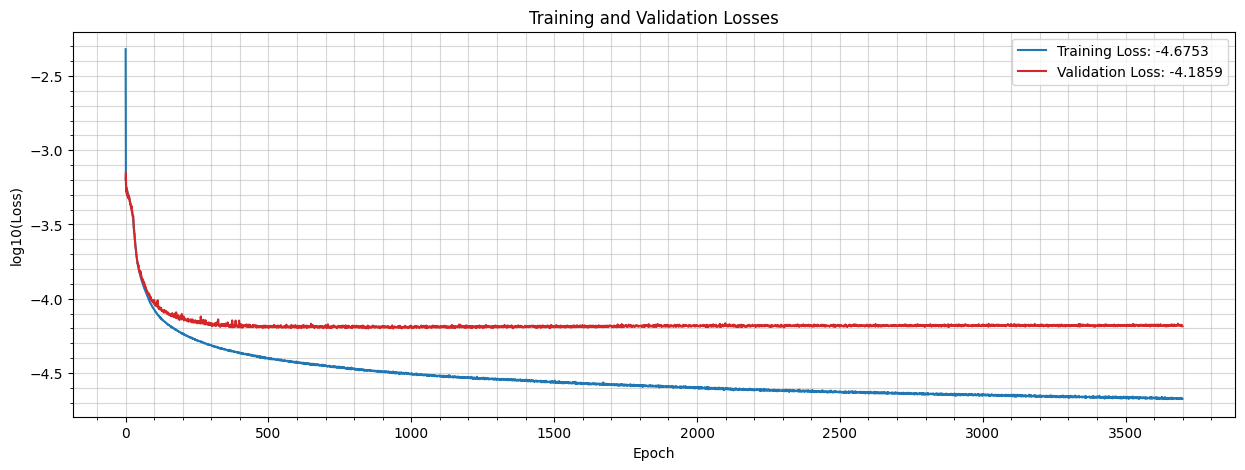

Epoch: 4000/5000.. Training loss: 0.965775 (dB/Hz)^2.. Validation Loss: 3.119736 (dB/Hz)^2


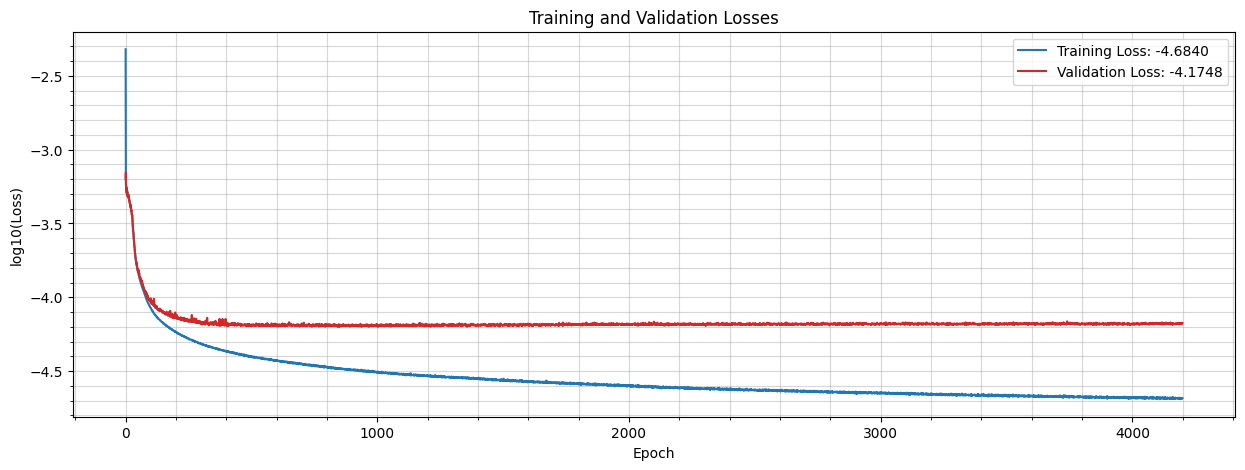

Epoch: 4500/5000.. Training loss: 0.925884 (dB/Hz)^2.. Validation Loss: 3.087874 (dB/Hz)^2


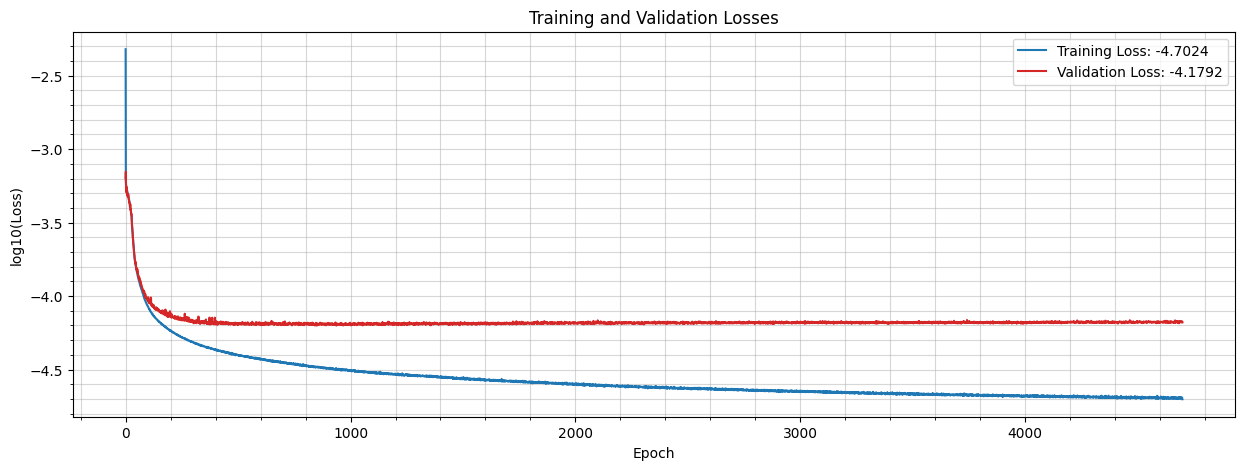

KeyboardInterrupt: 

In [30]:
num_epochs = 5000
#val_loss_min = 1
 
for epoch in range(1, num_epochs + 1):

    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs) # Calculate outputs (forward pass)
        loss = criterion(outputs, targets) # Calculate loss

        # Backward pass
        loss.backward() # Calculate gradients
        optimizer.step() # Update weights

        running_loss += loss.item() * inputs.size(0) # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset) # Calculate average loss over an epoch
    train_losses.append(avg_train_loss) #Epoch training losses for plotting

    # Validation phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss) # Append average validation loss for the epoch

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {convert_to_real_loss(train_losses[-1]):.6f} (dB/Hz)^2.. Validation Loss: {convert_to_real_loss(val_losses[-1]):.6f} (dB/Hz)^2")
        #plot_training_progress(real_train_losses, real_val_losses, ylabel = "Loss (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    #'''
    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(model.state_dict(), model_name + "val_min.pth")
        val_loss_min = avg_val_loss
    #'''

In [31]:
# Save model
torch.save(model.state_dict(), model_path)

# Save training and validation losses
np.save(train_losses_path, np.array(train_losses))
np.save(val_losses_path, np.array(val_losses))


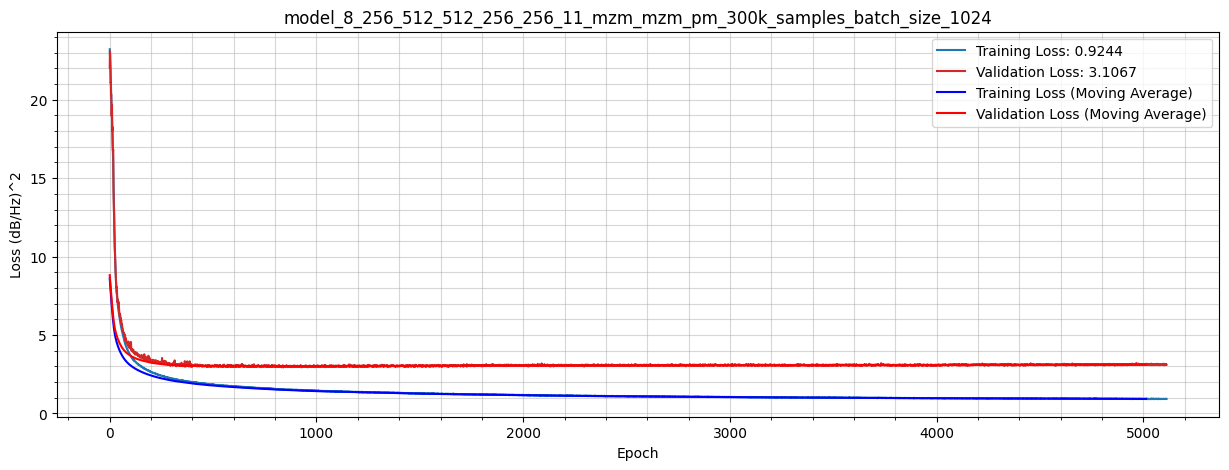

In [32]:
real_train_losses = convert_to_real_loss(train_losses)
real_val_losses = convert_to_real_loss(val_losses)
plot_training_progress(real_train_losses[10:], real_val_losses[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 100)

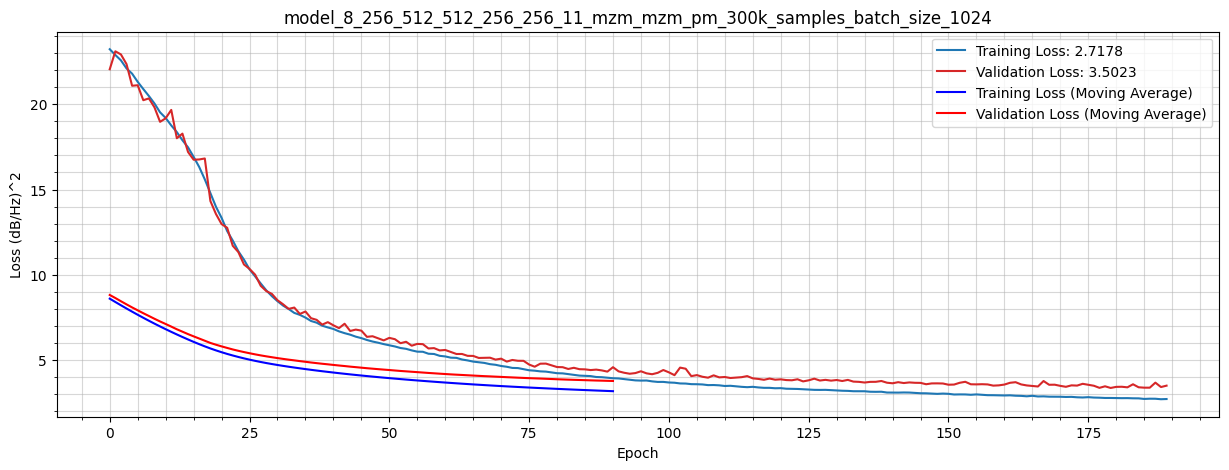

In [28]:
real_train_losses = convert_to_real_loss(train_losses)
real_val_losses = convert_to_real_loss(val_losses)
plot_training_progress(real_train_losses[10:], real_val_losses[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 100)

Normalized Loss: 0.000009
Denormalized Loss: 0.415732 (dB/Hz)^2


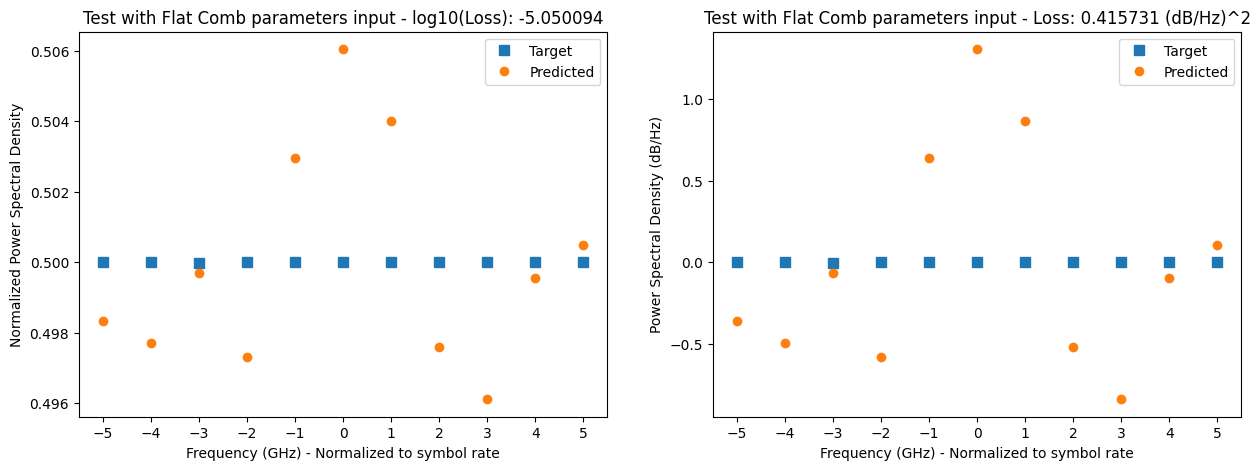

In [39]:
# Test with flat comb
model.eval() # Set model to evaluation mode
with torch.no_grad():
    params = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06] # flat comb parameters
    #params = [4.06272973, 3.43462156, 1.56805446, 1.56803667, 2.97554328, 1.47611193] # Flat comb parameters (DDMZM)

    input = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = torch.tensor(frequencyCombPeaks(params), dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = target_non_norm - torch.mean(target_non_norm)
    target = train_dataset.normalize(target_non_norm)
    output = model(input)
    
    #plot using subplots, side by side
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),output.squeeze().cpu().numpy(),"o", label='Predicted')
    ax[0].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[0].set_ylabel("Normalized Power Spectral Density")
    ax[0].legend()
    loss = criterion(output, target).item()
    ax[0].set_title(f'Test with Flat Comb parameters input - log10(Loss): {np.log10(loss):.6f}')

    print(f"Normalized Loss: {loss:.6f}")
    print(f"Denormalized Loss: {convert_to_real_loss(loss):.6f} (dB/Hz)^2")
    
    # Denormalize
    output = train_dataset.denormalize(output)
    target = train_dataset.denormalize(target)

    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),output.squeeze().cpu().numpy(),"o", label='Predicted')
    ax[1].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
    ax[1].legend()
    #real_loss = convert_to_real_loss(loss)
    real_loss = criterion(output, target).item()
    ax[1].set_title(f'Test with Flat Comb parameters input - Loss: {real_loss:.6f} (dB/Hz)^2')   

Test Loss: 3.133559 (dB/Hz)^2


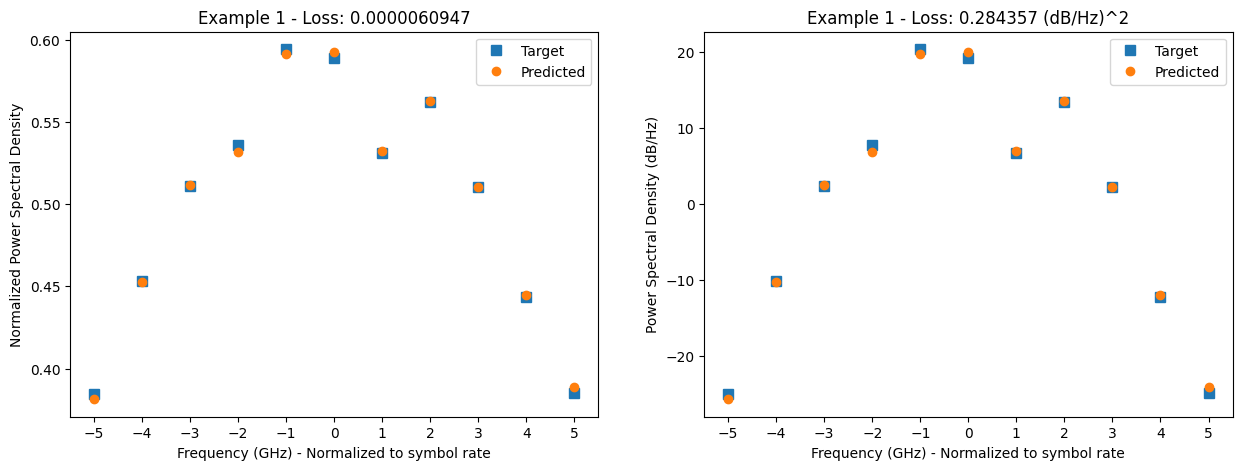

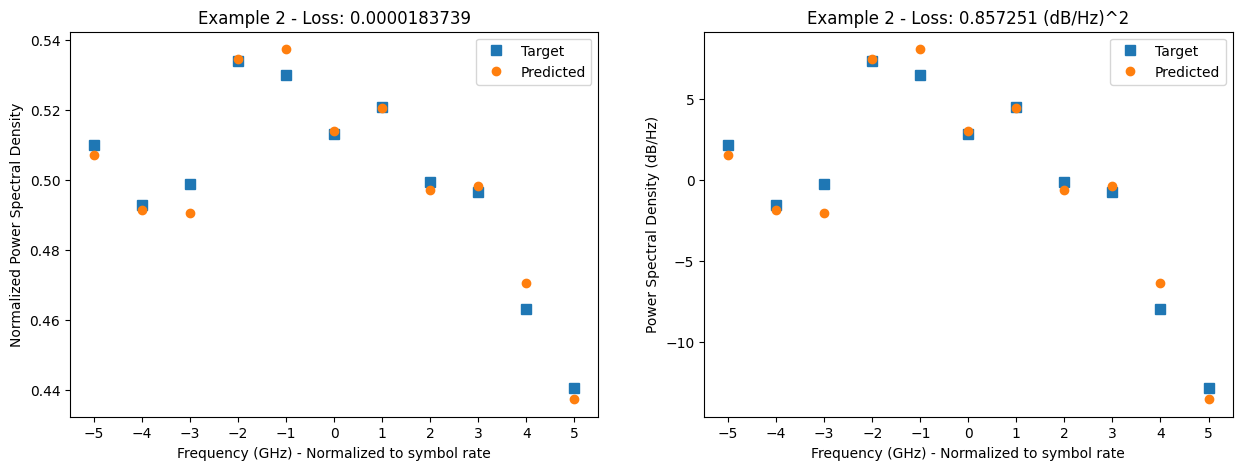

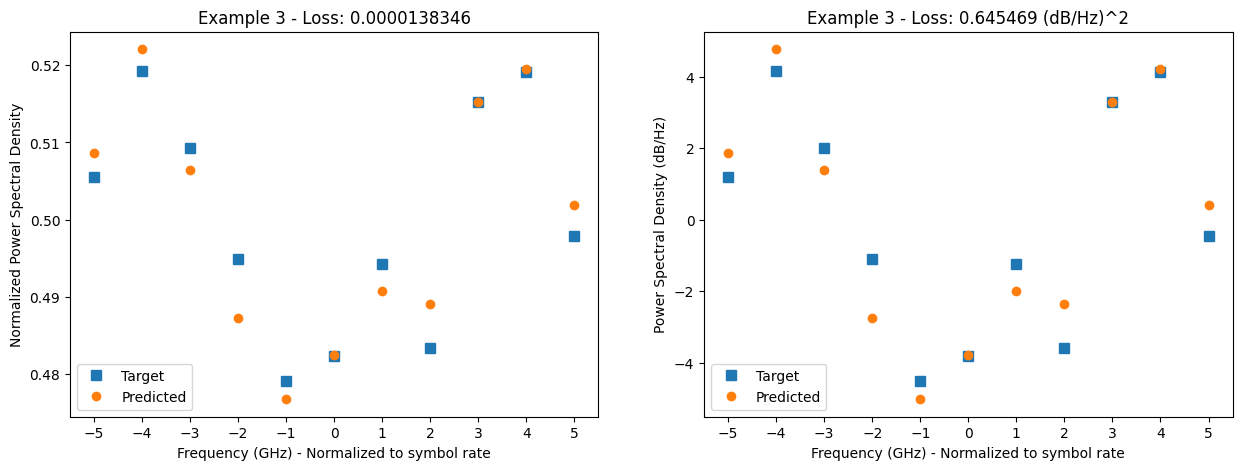

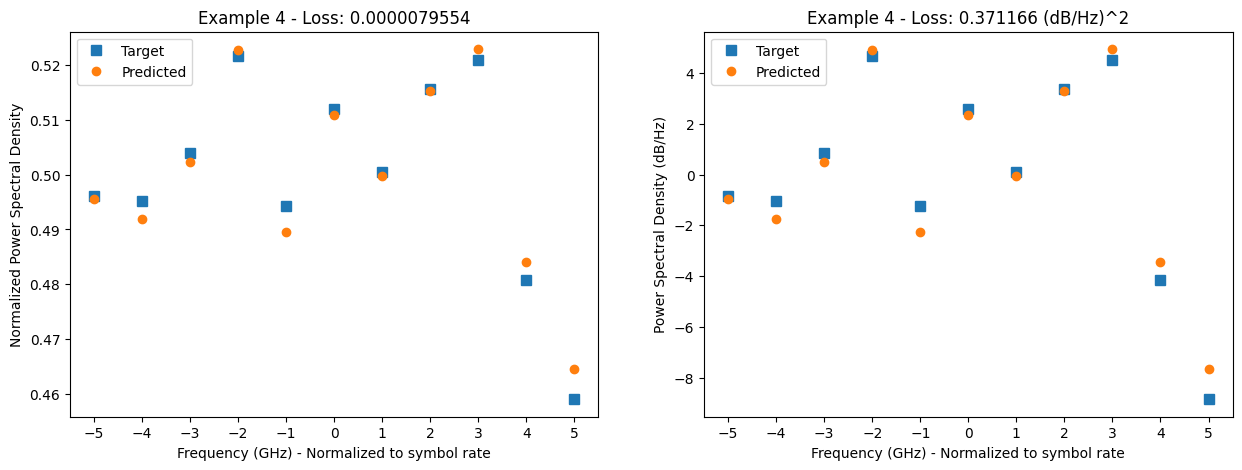

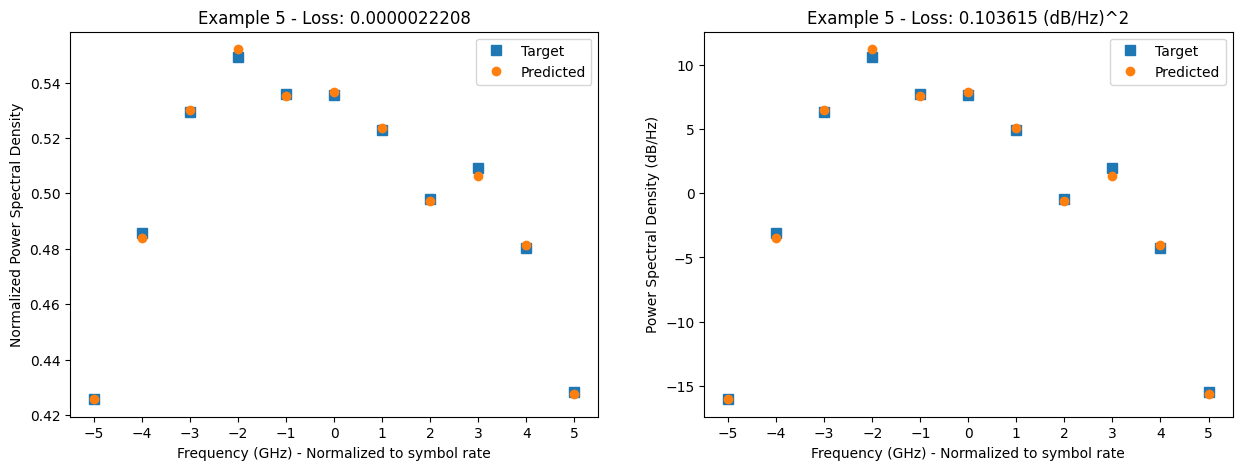

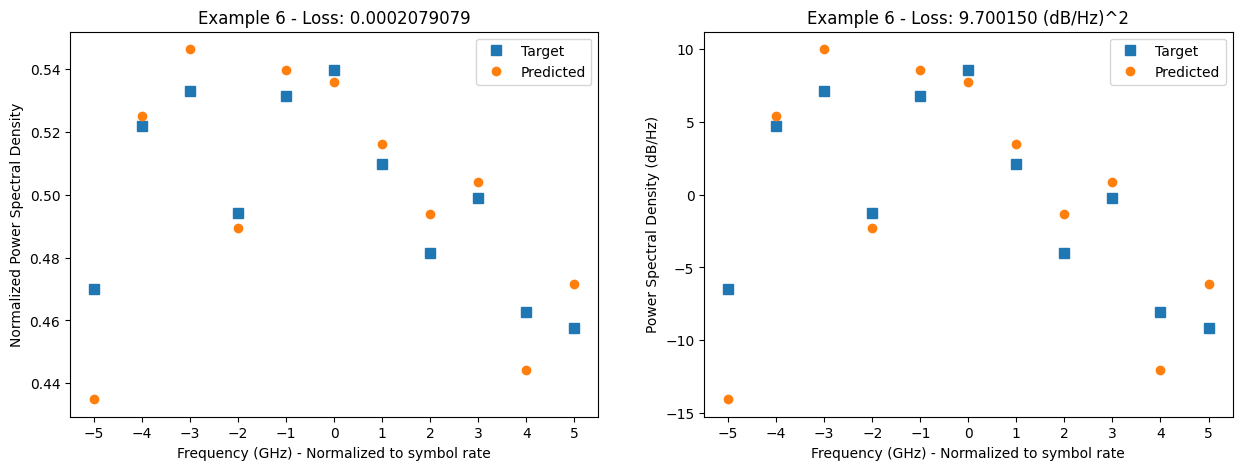

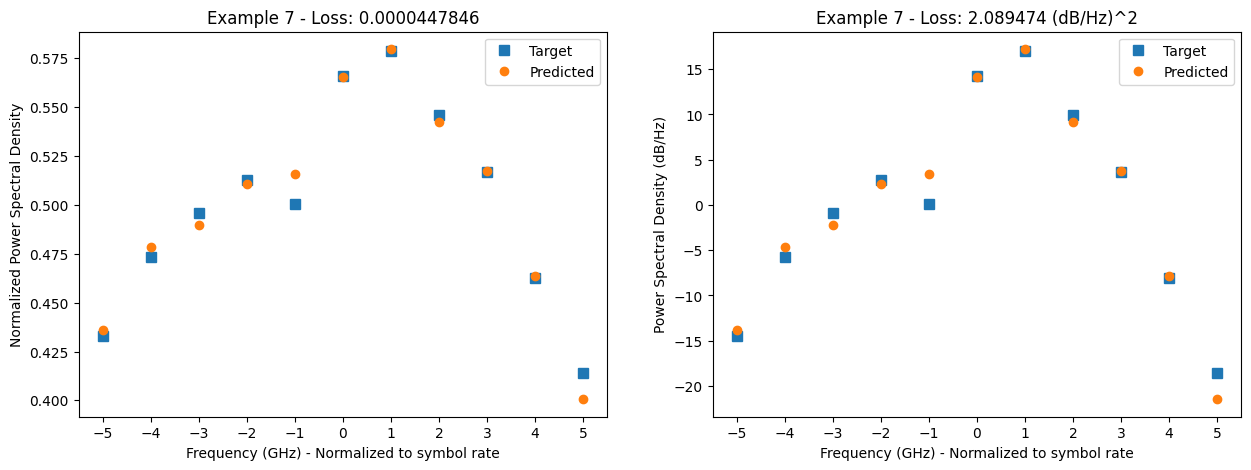

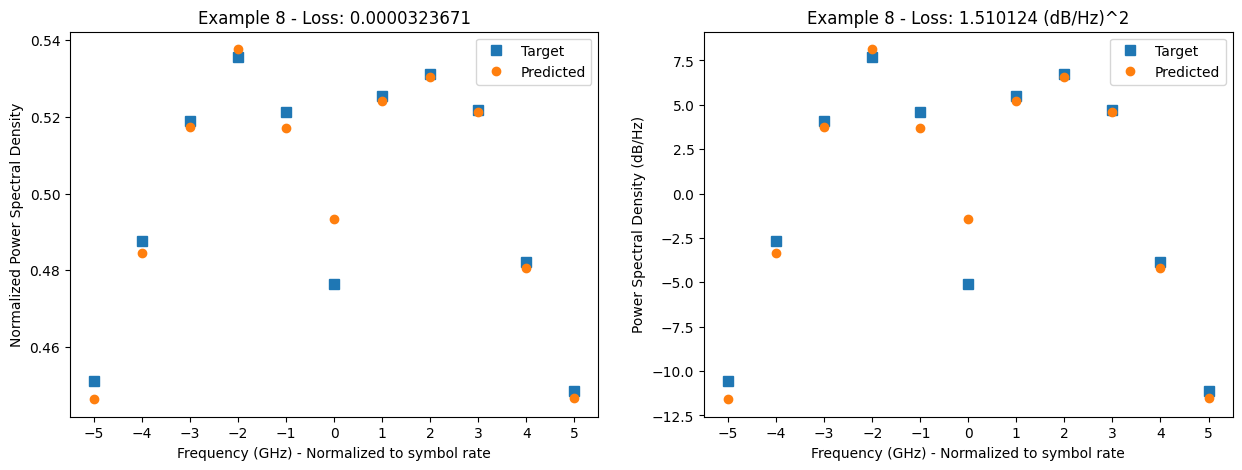

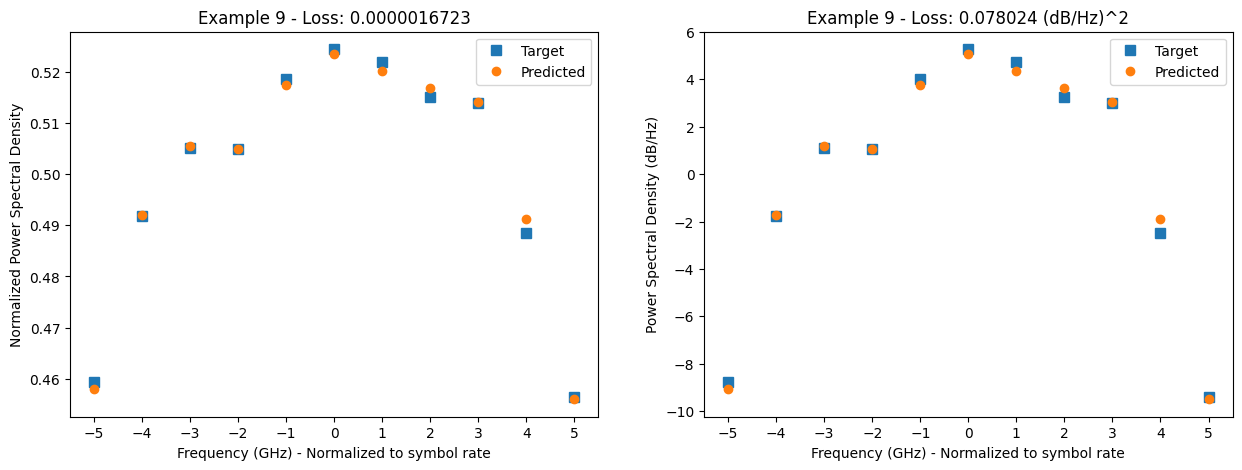

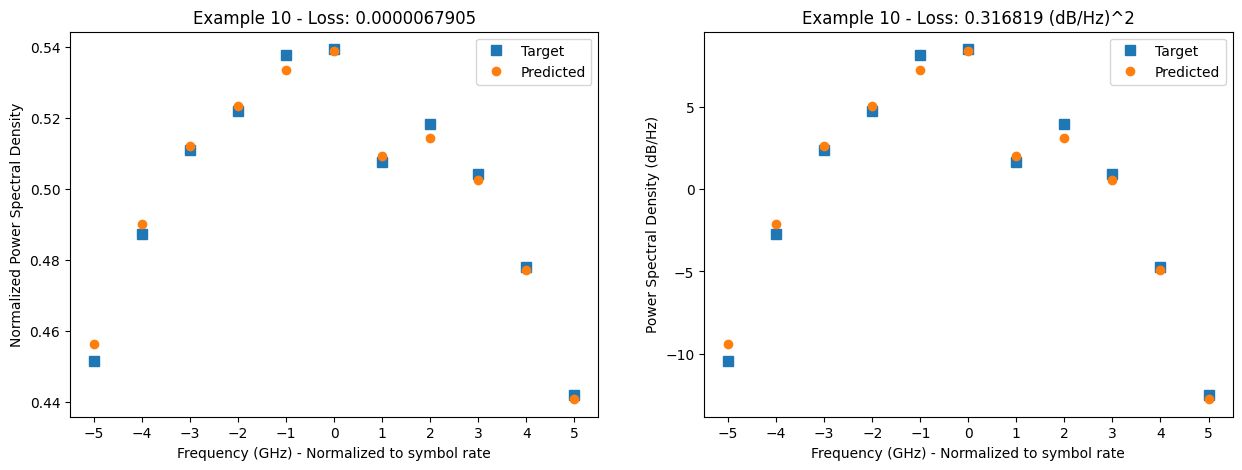

In [40]:
# Test phase
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    running_test_loss = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss = criterion(outputs, targets)
        running_test_loss += test_loss.item() * inputs.size(0)
    avg_test_loss = running_test_loss / len(test_loader.dataset)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss):.6f} (dB/Hz)^2")


for i in range(min(10, inputs.shape[0])):  # Loop over the first n examples

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),targets[i].cpu().numpy(),"s", label='Target',markersize=7)
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),outputs[i].cpu().numpy(),"o", label='Predicted')
    ax[0].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[0].set_ylabel("Normalized Power Spectral Density")
    ax[0].legend()
    ax[0].set_title(f'Example {i+1} - Loss: {criterion(outputs[i], targets[i]).item():.10f}')

    # Denormalize
    outputs_denorm = train_dataset.denormalize(outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),targets_denorm.cpu().numpy(),"s", label='Target',markersize=7)
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),outputs_denorm.cpu().numpy(),"o", label='Predicted')
    ax[1].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
    ax[1].legend()
    ax[1].set_title(f'Example {i+1} - Loss: {criterion(outputs_denorm, targets_denorm).item():.6f} (dB/Hz)^2')

## <a id='toc3_2_'></a>[Inverse Network](#toc0_)

In [41]:
# Create data loaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

In [43]:
# Load the pre-trained forward model
model_name = "model_8_256_512_512_256_256_11_mzm_mzm_pm_300k_samples_batch_size_1024"
forward_model_name = "saved_data/models/" + model_name + ".pth"

forward_architecture = [8, 256, 512, 512, 256, 256, 11]
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(torch.load(forward_model_name))  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

# Create an inverse model with the same architecture but reversed
inverse_architecture = forward_architecture[::-1]
inverse_net = FrequencyCombNet(inverse_architecture).to(device)

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
optimizer = torch.optim.Adam(inverse_net.parameters(), lr = 0.001) # lr - learning rate

train_losses = []
val_losses = []

### <a id='toc3_2_1_'></a>[Forward Network --> Inverse Network](#toc0_)

Epoch: 10/100.. Training loss: 2.713511 (dB/Hz)^2.. Validation Loss: 2.705692 (dB/Hz)^2


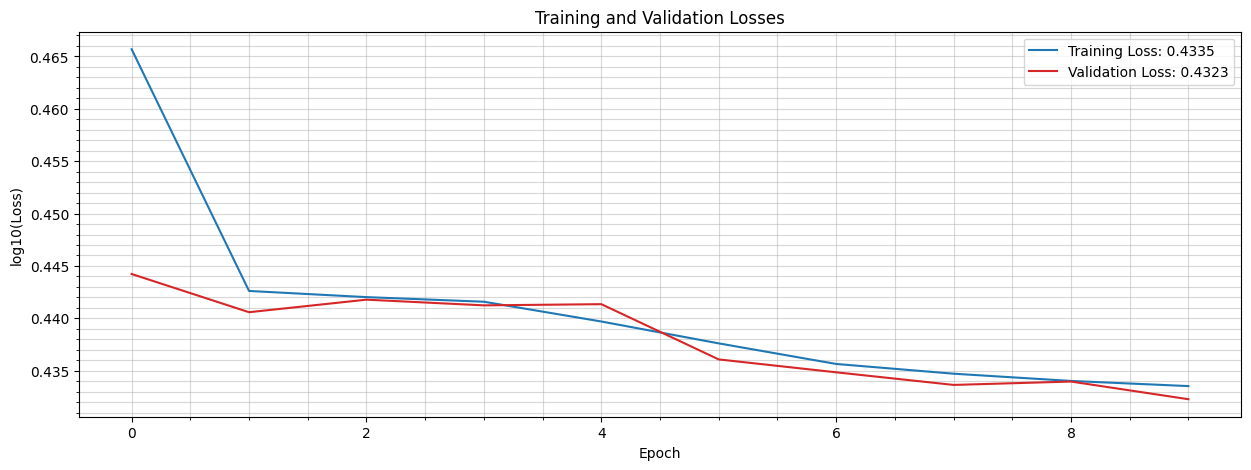

Epoch: 20/100.. Training loss: 2.700379 (dB/Hz)^2.. Validation Loss: 2.698658 (dB/Hz)^2


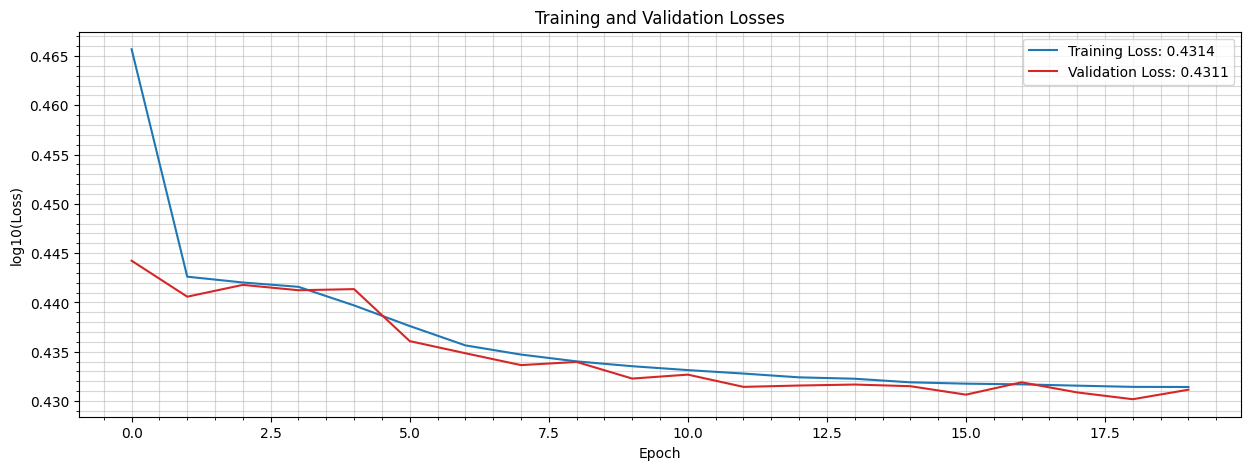

Epoch: 30/100.. Training loss: 2.694899 (dB/Hz)^2.. Validation Loss: 2.692784 (dB/Hz)^2


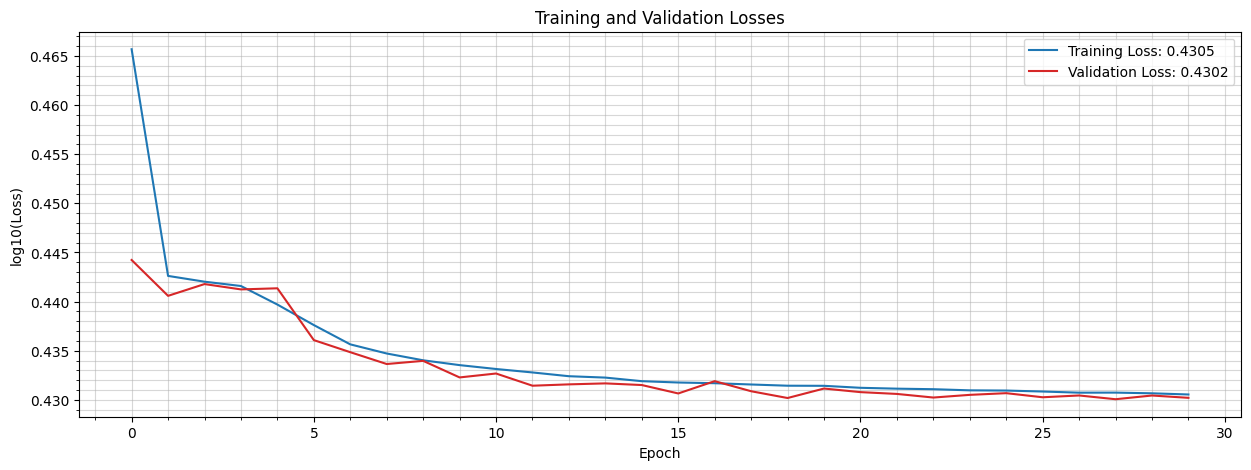

Epoch: 40/100.. Training loss: 2.691471 (dB/Hz)^2.. Validation Loss: 2.695551 (dB/Hz)^2


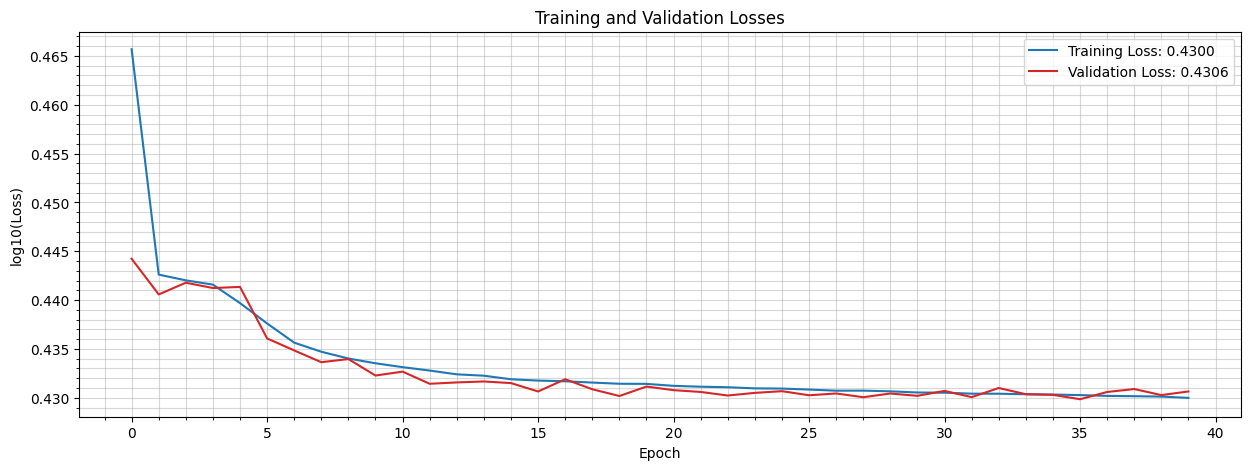

Epoch: 50/100.. Training loss: 2.687763 (dB/Hz)^2.. Validation Loss: 2.695087 (dB/Hz)^2


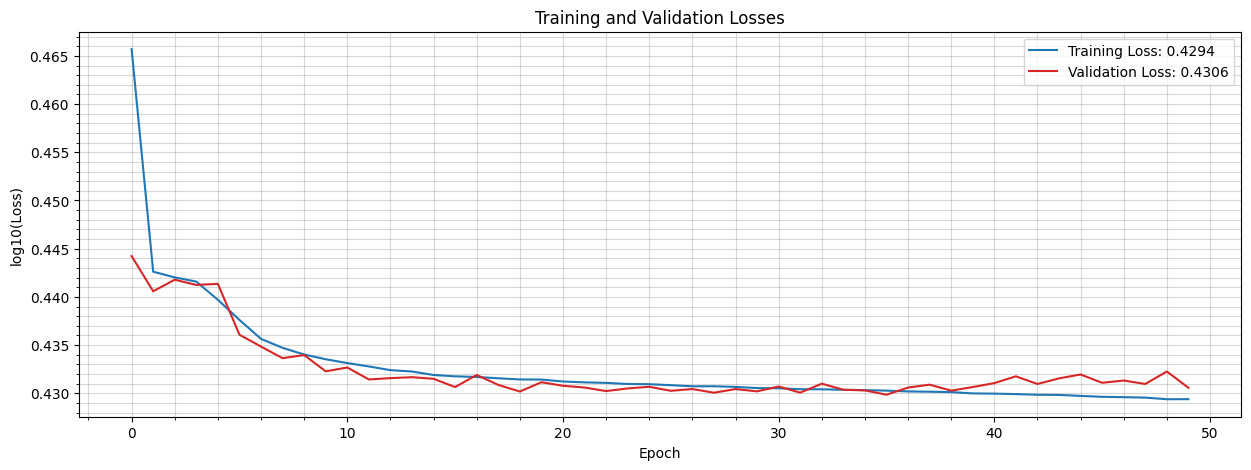

Epoch: 60/100.. Training loss: 2.682099 (dB/Hz)^2.. Validation Loss: 2.703360 (dB/Hz)^2


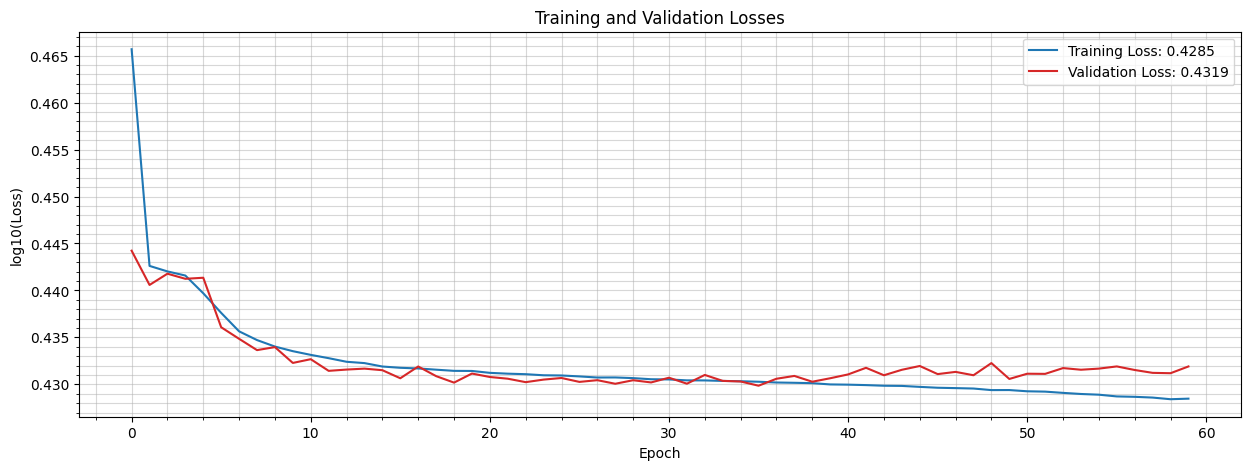

Epoch: 70/100.. Training loss: 2.674076 (dB/Hz)^2.. Validation Loss: 2.705535 (dB/Hz)^2


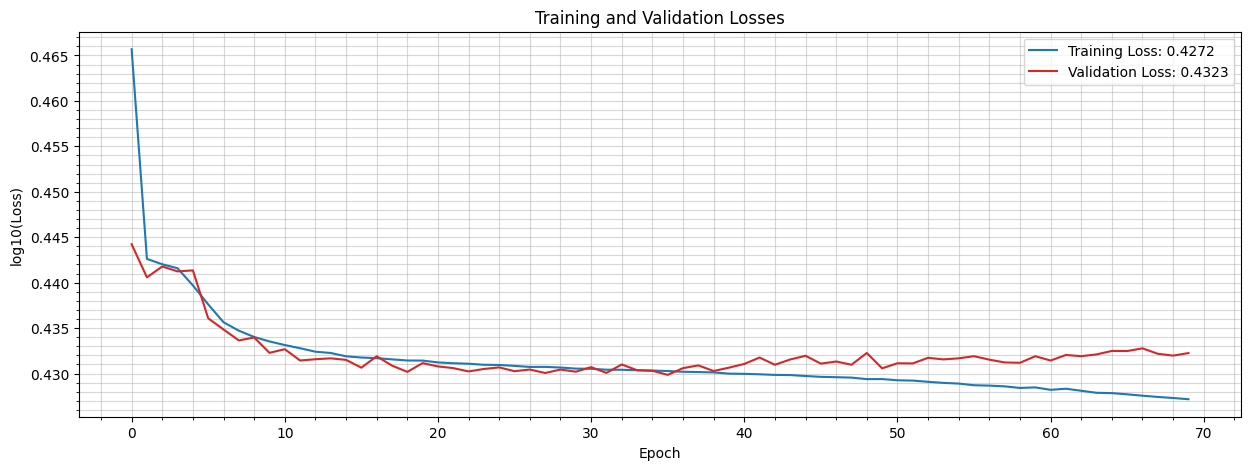

Epoch: 80/100.. Training loss: 2.666191 (dB/Hz)^2.. Validation Loss: 2.710946 (dB/Hz)^2


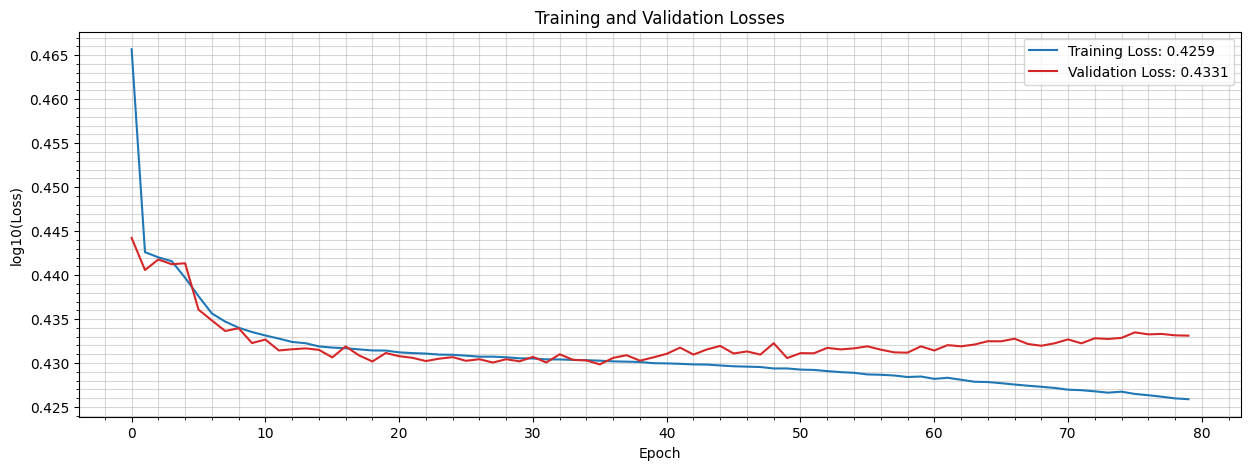

Epoch: 90/100.. Training loss: 2.658142 (dB/Hz)^2.. Validation Loss: 2.715918 (dB/Hz)^2


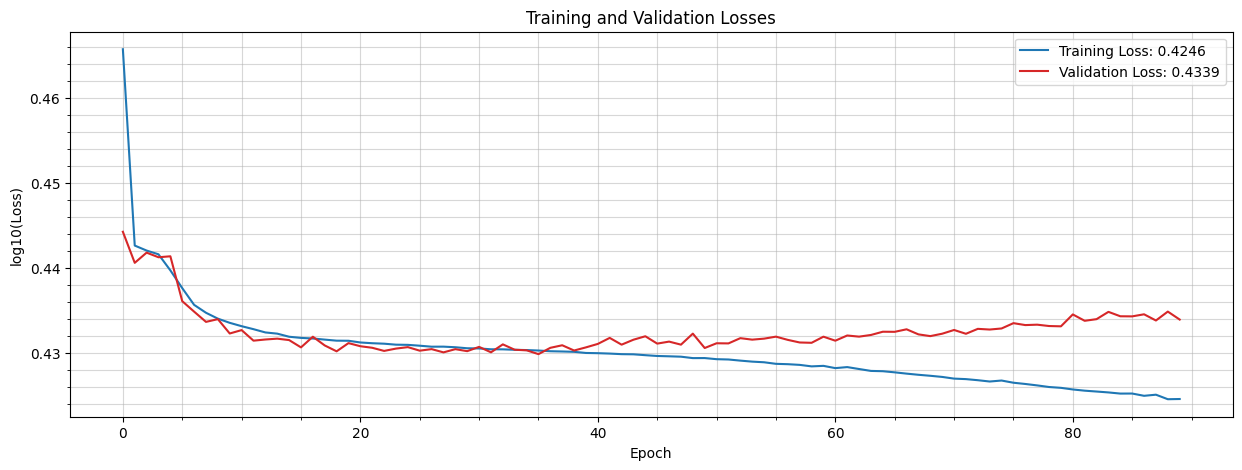

Epoch: 100/100.. Training loss: 2.648420 (dB/Hz)^2.. Validation Loss: 2.724369 (dB/Hz)^2


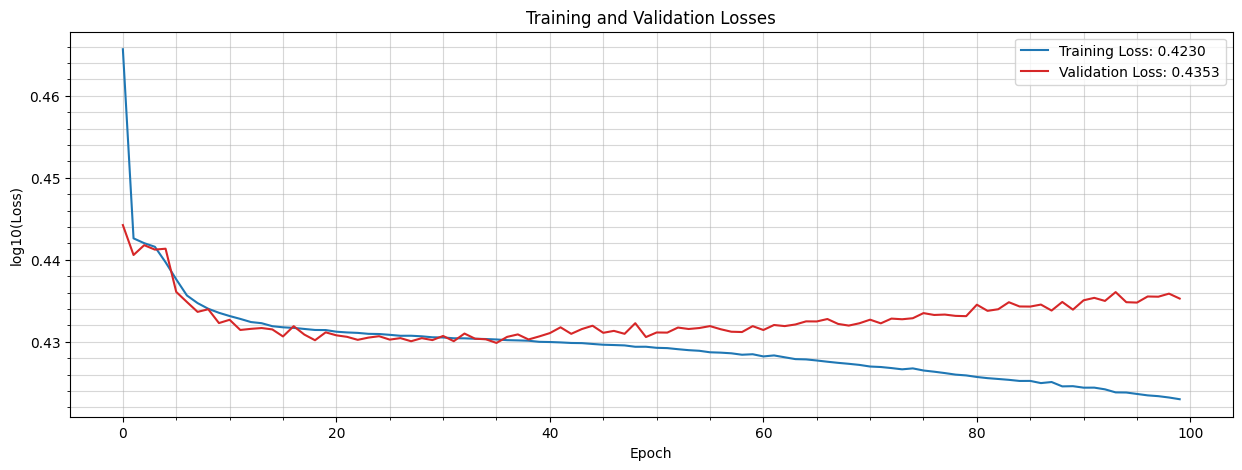

In [23]:
num_epochs = 100
val_loss_min = 1
for epoch in range(1, num_epochs + 1):

    # Training phase
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the forward model
        forward_outputs = forward_net(inputs)
        
        # Forward pass through the inverse model
        inverse_outputs = inverse_net(forward_outputs)

        # Calculate loss
        loss = criterion(inverse_outputs, inputs)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    #'''
    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = forward_net(inputs)
            inverse_outputs = inverse_net(outputs)
            val_loss = criterion(inverse_outputs, inputs)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch
    #'''

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {avg_train_loss:.6f}.. Validation Loss: {avg_val_loss:.6f}")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    '''
    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Saving model...')
        torch.save(inverse_net.state_dict(), model_name + "val_min_inverse_net_1.pth")
        val_loss_min = avg_val_loss
    '''


### <a id='toc3_2_2_'></a>[Inverse Network --> Forward Network](#toc0_)

Validation loss decreased (0.000098 --> 0.000097). Epoch: 22. Saving model...
Validation loss decreased (0.000097 --> 0.000097). Epoch: 45. Saving model...
Epoch: 50/500... Training loss: 5.249918 (dB/Hz)^2 ... Validation Loss: 5.039695 (dB/Hz)^2


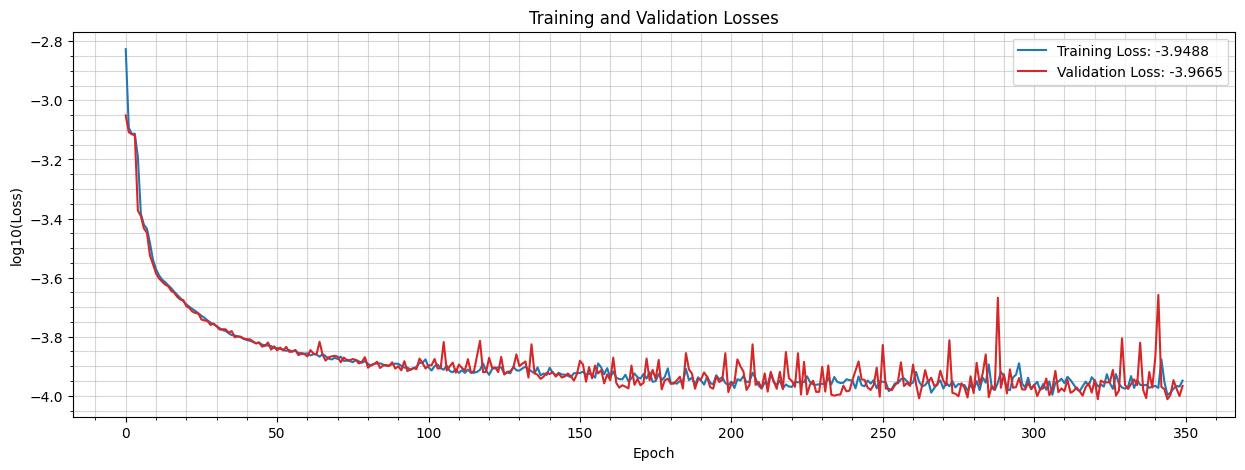

Validation loss decreased (0.000097 --> 0.000095). Epoch: 53. Saving model...
Epoch: 100/500... Training loss: 5.387126 (dB/Hz)^2 ... Validation Loss: 5.621563 (dB/Hz)^2


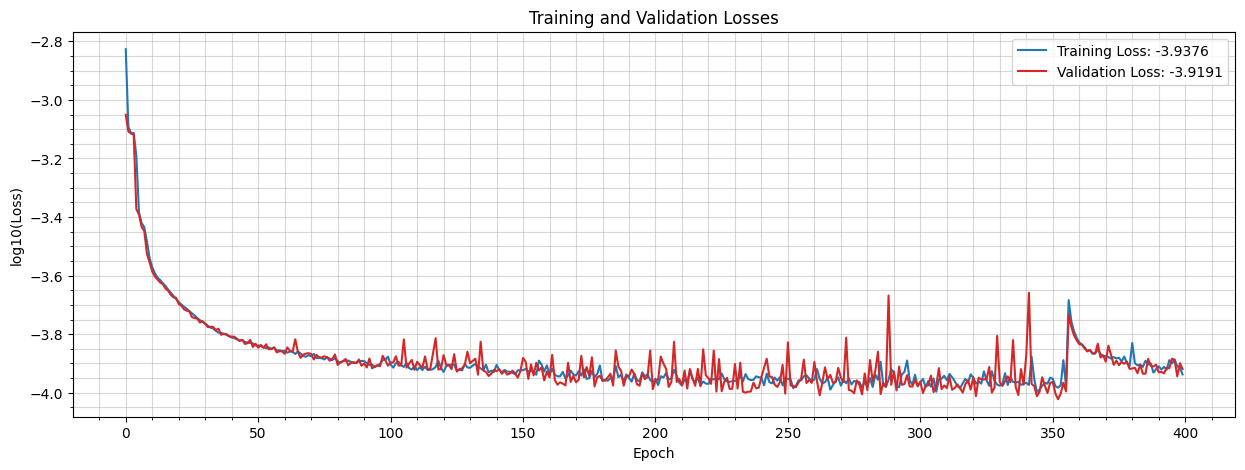

Epoch: 150/500... Training loss: 5.145365 (dB/Hz)^2 ... Validation Loss: 4.865184 (dB/Hz)^2


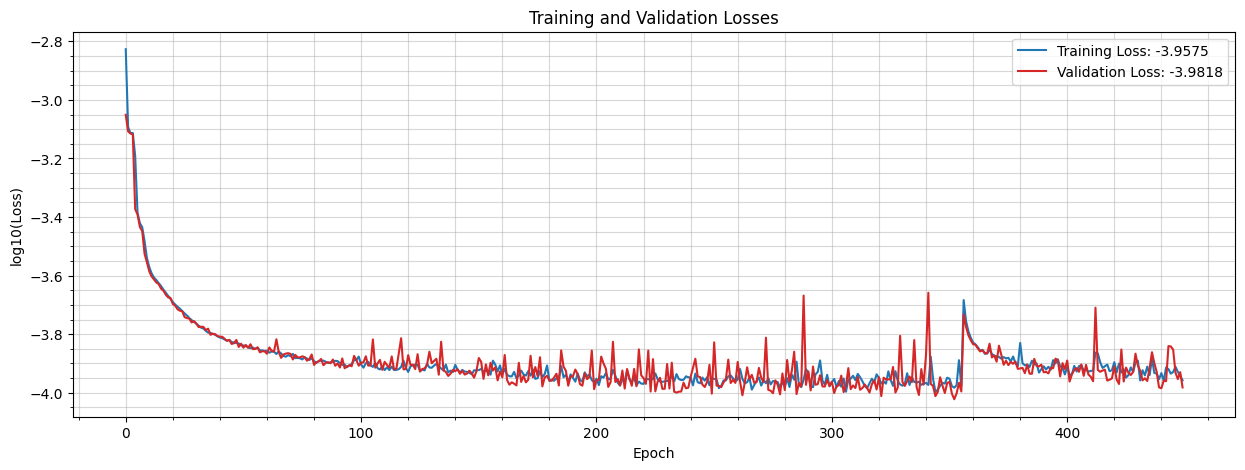

Epoch: 200/500... Training loss: 5.610537 (dB/Hz)^2 ... Validation Loss: 6.023033 (dB/Hz)^2


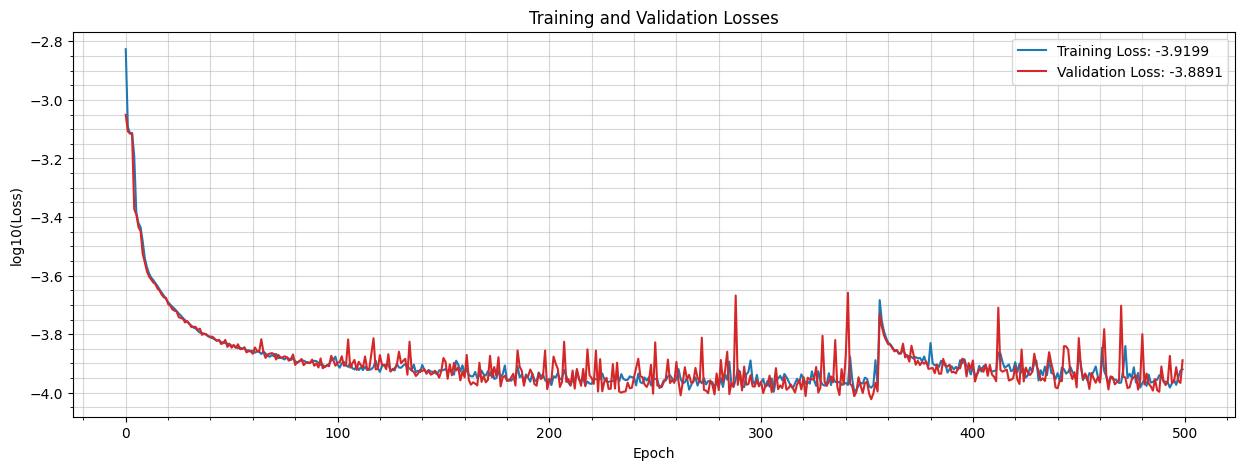

Epoch: 250/500... Training loss: 5.328790 (dB/Hz)^2 ... Validation Loss: 4.843754 (dB/Hz)^2


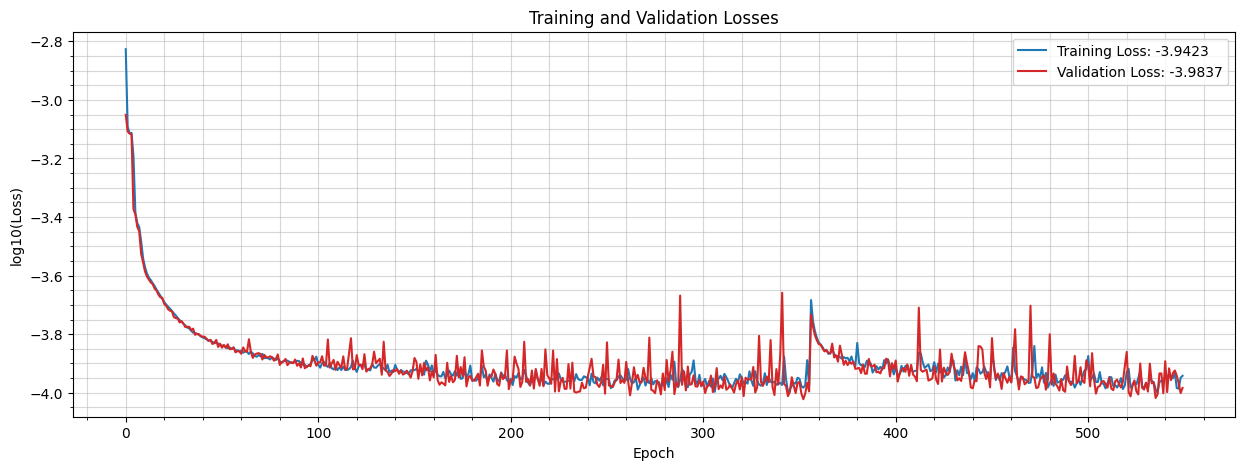

Validation loss decreased (0.000095 --> 0.000095). Epoch: 298. Saving model...
Epoch: 300/500... Training loss: 4.709100 (dB/Hz)^2 ... Validation Loss: 4.954327 (dB/Hz)^2


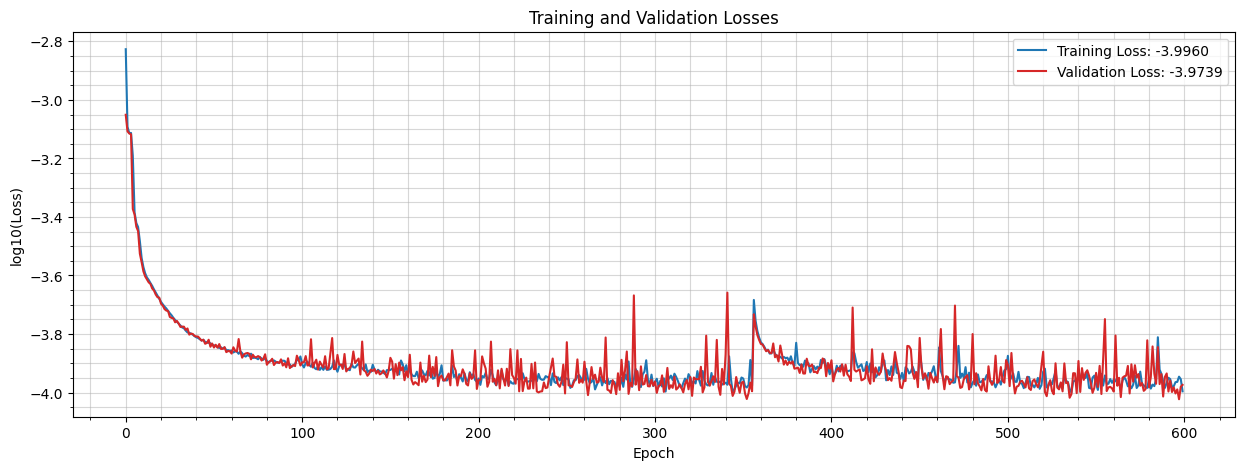

Validation loss decreased (0.000095 --> 0.000094). Epoch: 324. Saving model...
Epoch: 350/500... Training loss: 4.955009 (dB/Hz)^2 ... Validation Loss: 4.800031 (dB/Hz)^2


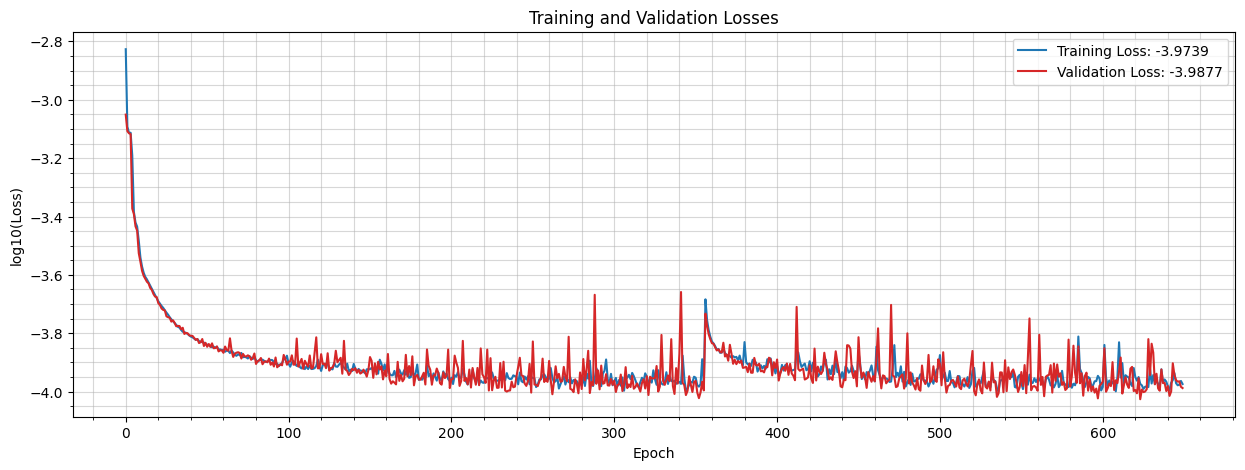

Validation loss decreased (0.000094 --> 0.000091). Epoch: 377. Saving model...
Epoch: 400/500... Training loss: 4.594228 (dB/Hz)^2 ... Validation Loss: 4.988242 (dB/Hz)^2


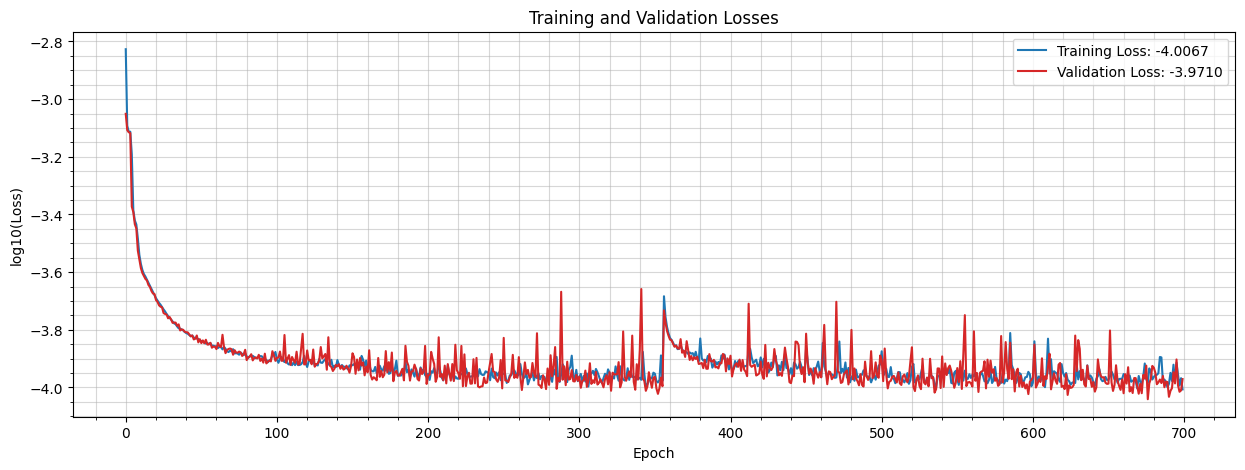

Validation loss decreased (0.000091 --> 0.000090). Epoch: 407. Saving model...
Epoch: 450/500... Training loss: 4.635755 (dB/Hz)^2 ... Validation Loss: 4.644399 (dB/Hz)^2


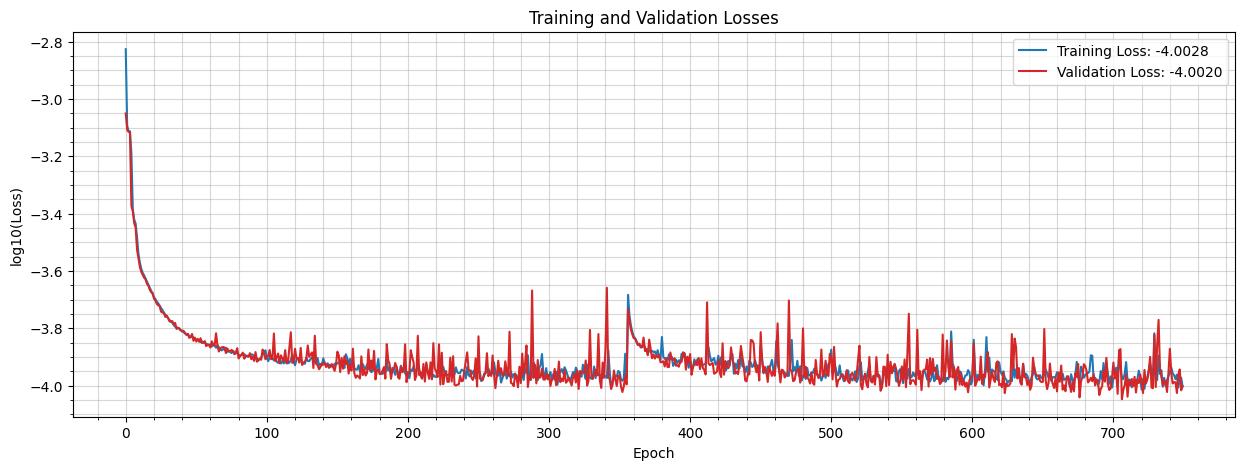

Epoch: 500/500... Training loss: 4.940893 (dB/Hz)^2 ... Validation Loss: 4.825003 (dB/Hz)^2


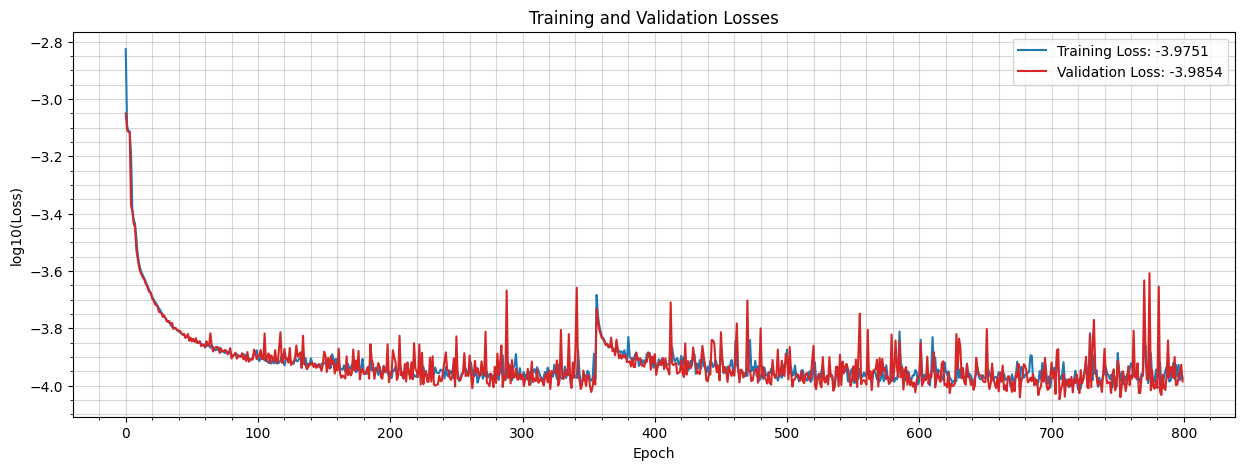

In [59]:
num_epochs = 500
#val_loss_min = 1
for epoch in range(1, num_epochs + 1):

    # Training phase
    forward_net.eval()  # Set model to evaluation mode
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for _, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        targets = targets.to(device)

        # Forward pass through the inverse model
        inverse_outputs = inverse_net(targets)

        # Forward pass through the forward model
        forward_outputs = forward_net(inverse_outputs)

        # Calculate loss
        loss = criterion(forward_outputs, targets)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * targets.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for _, targets in val_loader:
            targets = targets.to(device)
            inverse_outputs = inverse_net(targets)
            forward_outputs = forward_net(inverse_outputs)
            val_loss = criterion(forward_outputs, targets)
            running_val_loss += val_loss.item() * targets.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    #'''
    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(inverse_net.state_dict(), model_name + "val_min_inverse_net.pth")
        val_loss_min = avg_val_loss
    #'''

In [63]:
# Save the inverse model
torch.save(inverse_net.state_dict(), model_name + "inverse_net.pth")

#save training and validation losses for the inverse model
inverse_train_losses_path = "saved_data/losses/" + model_name + '_inverse_train_losses.npy'
inverse_val_losses_path = "saved_data/losses/" + model_name + '_inverse_val_losses.npy'
np.save(inverse_train_losses_path, np.array(train_losses))
np.save(inverse_val_losses_path, np.array(val_losses))

Normalized Loss: 0.000006
Denormalized Loss: 0.272013 (dB/Hz)^2


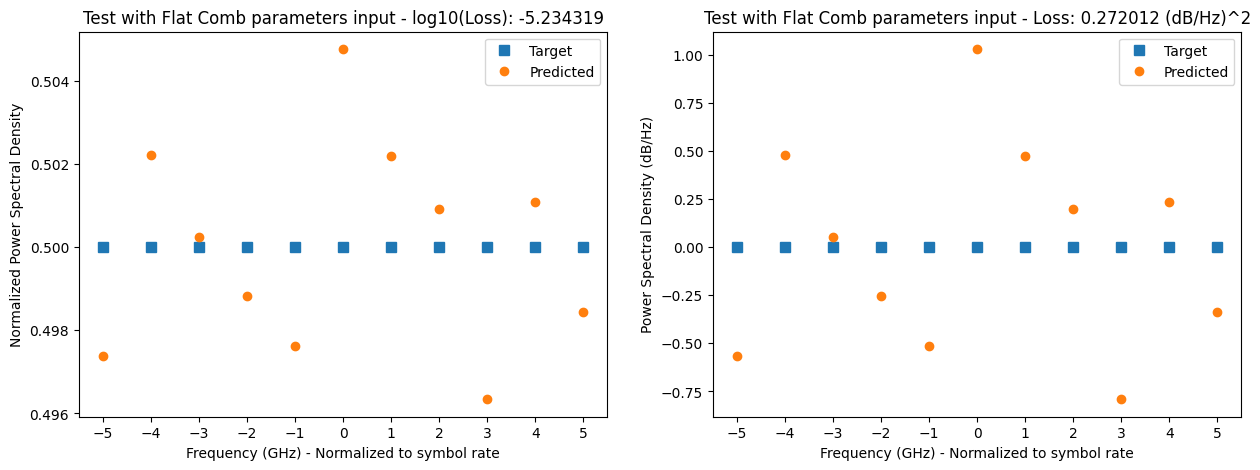

In [64]:
# Test with flat comb
inverse_net.eval() # Set inverse_net to evaluation mode
with torch.no_grad():
    params = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06] # flat comb parameters
    #params = [4.06272973, 3.43462156, 1.56805446, 1.56803667, 2.97554328, 1.47611193] # Flat comb parameters (DDMZM)

    input = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = torch.tensor(frequencyCombPeaks(params), dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = target_non_norm - torch.mean(target_non_norm)
    target = train_dataset.normalize(target_non_norm)
    
    inverse_output = inverse_net(target)
    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_output.cpu().numpy()[0]), dtype=torch.float32).unsqueeze(0).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    #plot using subplots, side by side
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),inverse_peaks.squeeze().cpu().numpy(),"o", label='Predicted')
    ax[0].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[0].set_ylabel("Normalized Power Spectral Density")
    ax[0].legend()
    loss = criterion(inverse_peaks, target).item()
    ax[0].set_title(f'Test with Flat Comb parameters input - log10(Loss): {np.log10(loss):.6f}')

    print(f"Normalized Loss: {loss:.6f}")
    print(f"Denormalized Loss: {convert_to_real_loss(loss):.6f} (dB/Hz)^2")
    
    # Denormalize
    inverse_peaks = train_dataset.denormalize(inverse_peaks)
    target = train_dataset.denormalize(target)

    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),inverse_peaks.squeeze().cpu().numpy(),"o", label='Predicted')
    ax[1].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
    ax[1].legend()
    #real_loss = convert_to_real_loss(loss)
    real_loss = criterion(inverse_peaks, target).item()
    ax[1].set_title(f'Test with Flat Comb parameters input - Loss: {real_loss:.6f} (dB/Hz)^2')   

Test Loss: 4.890005 (dB/Hz)^2


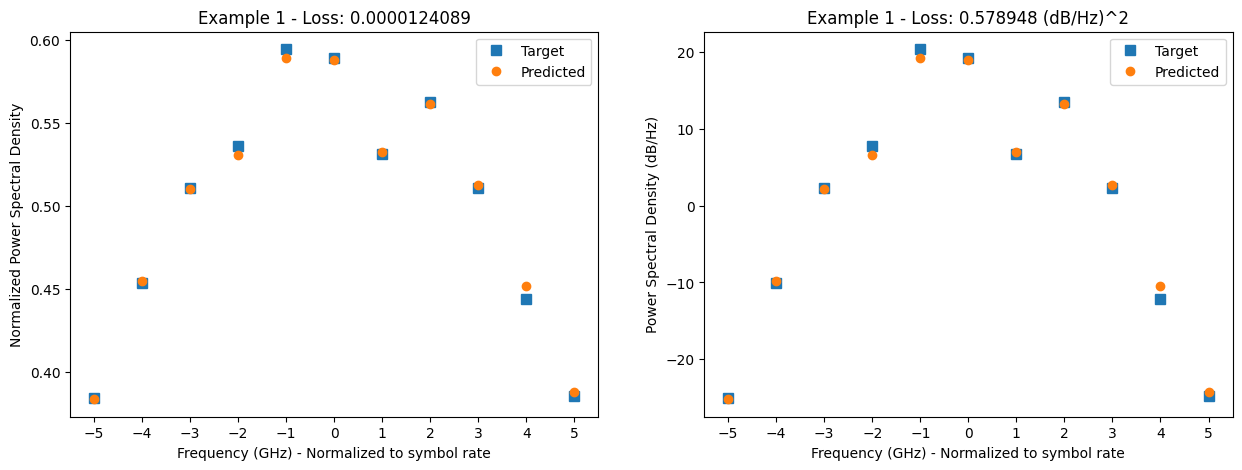

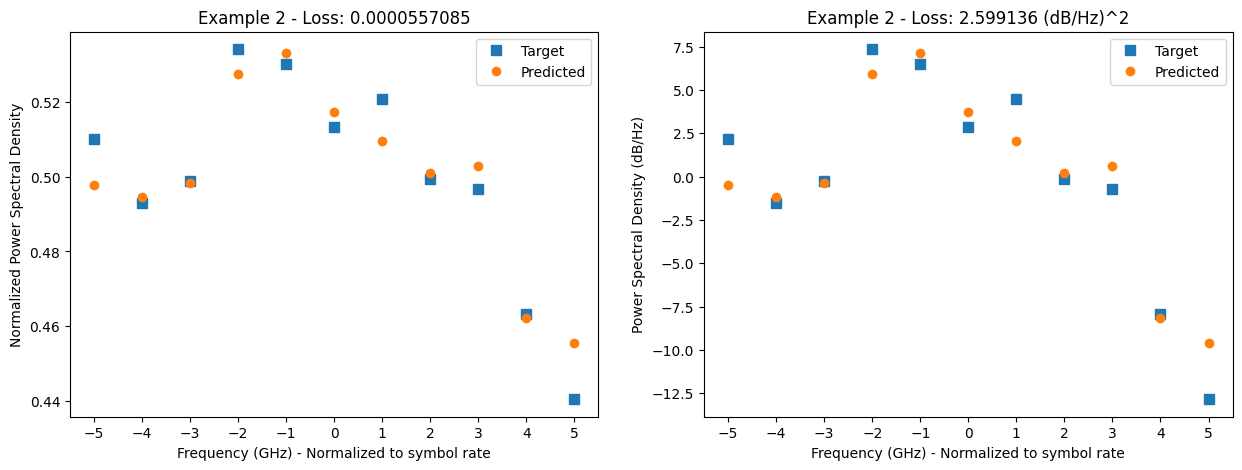

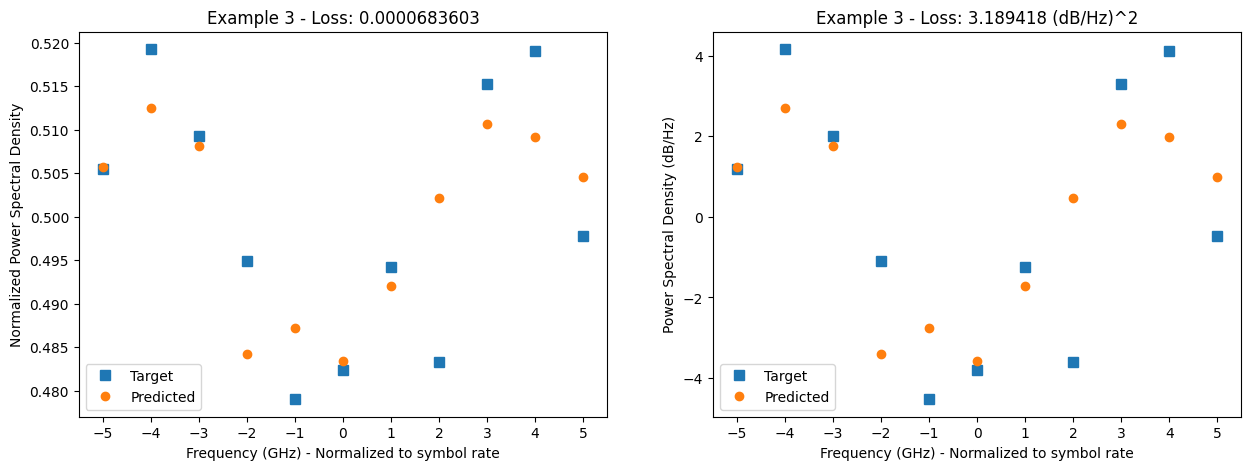

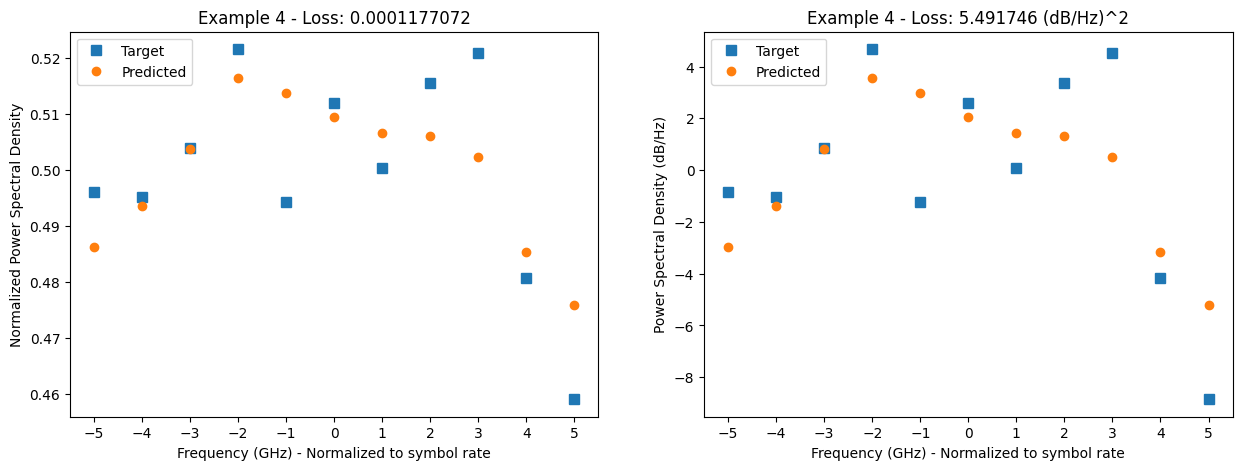

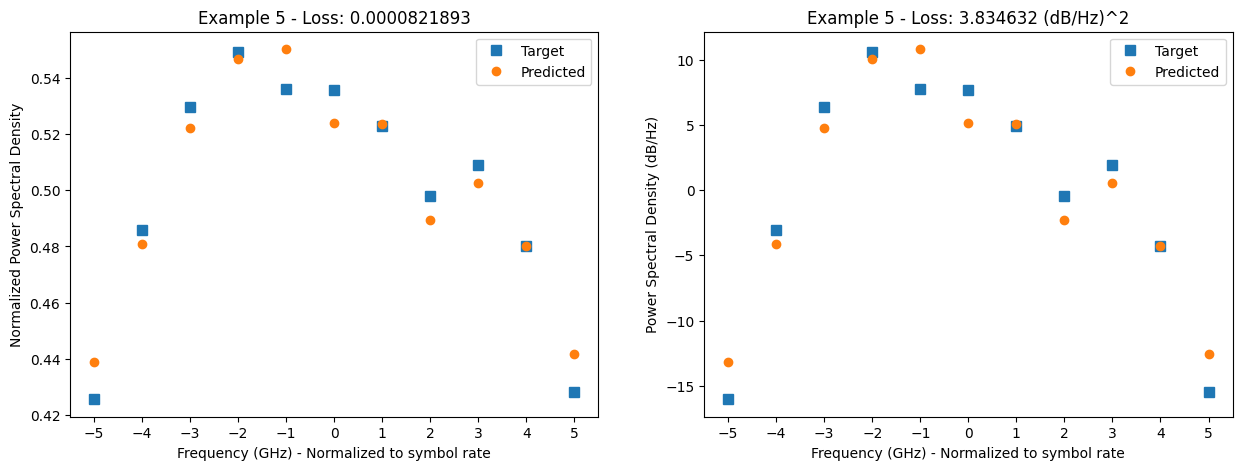

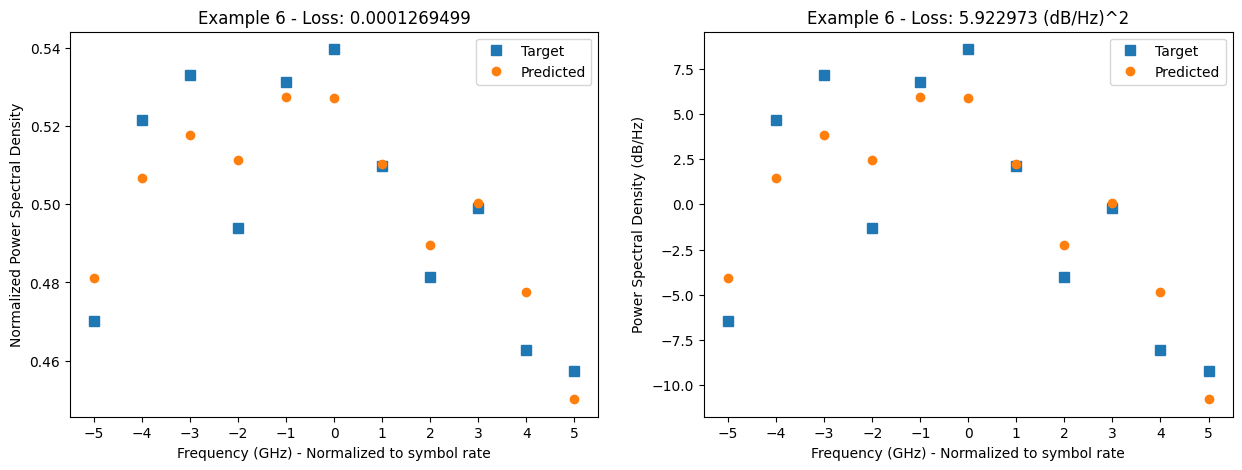

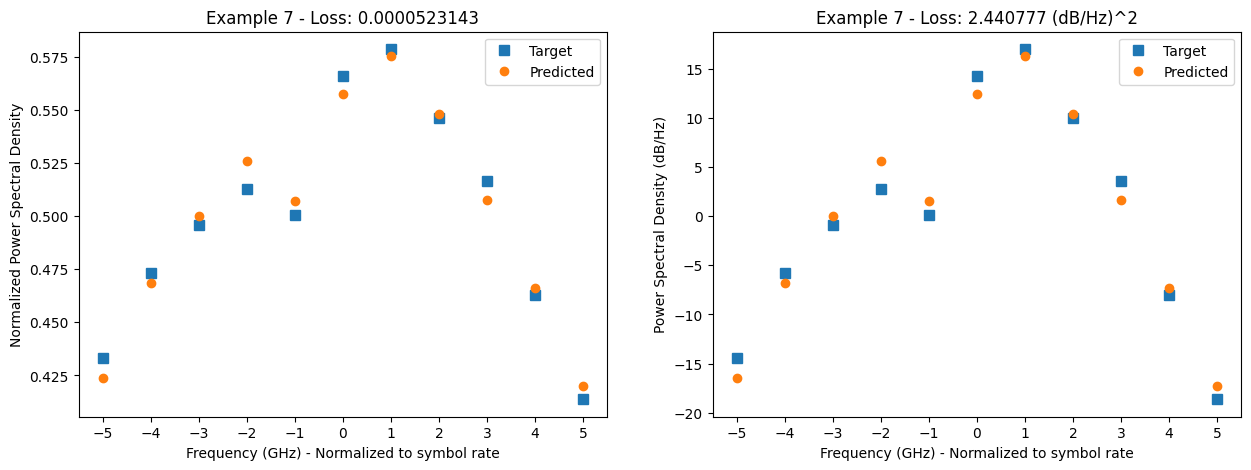

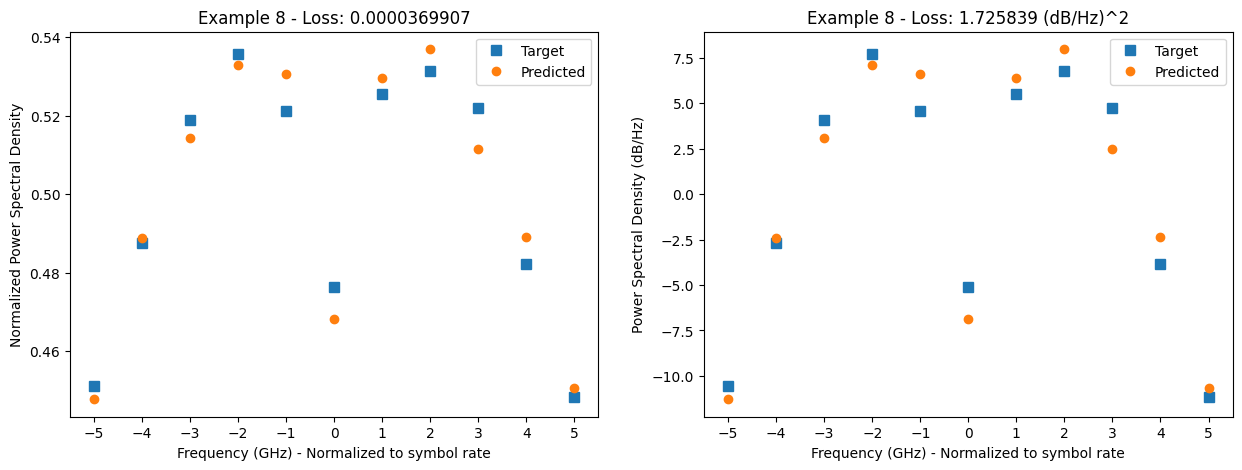

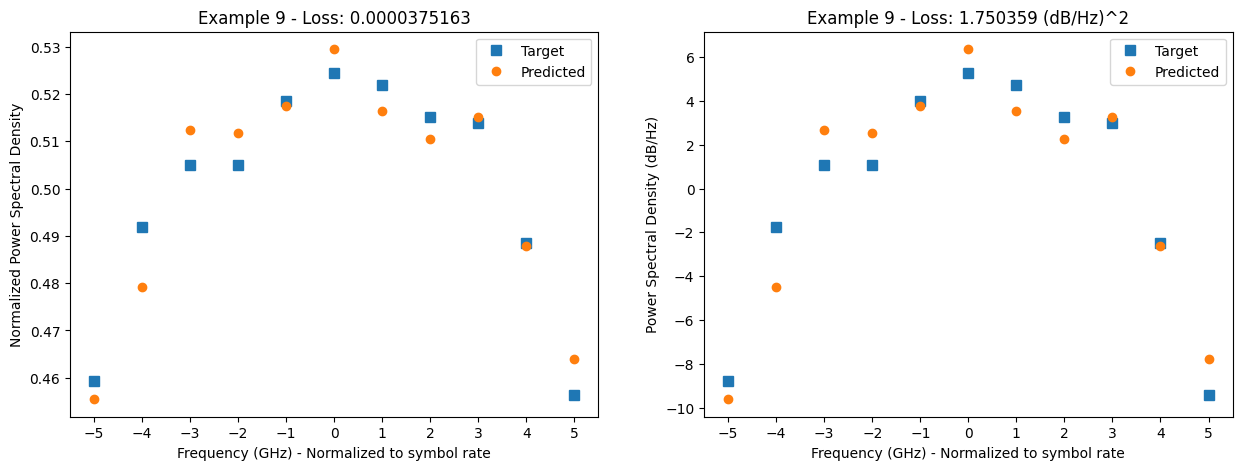

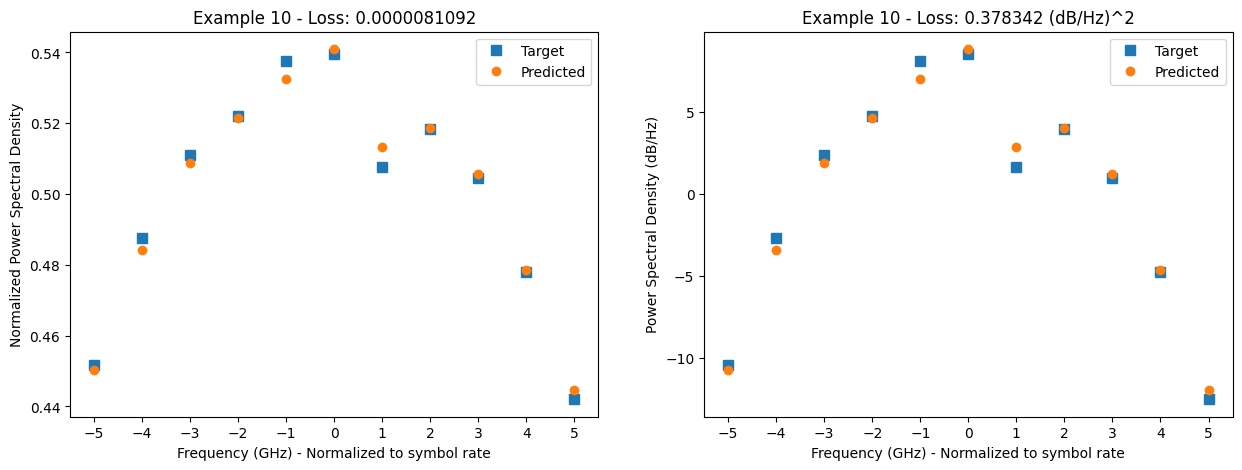

In [65]:
# Test phase
inverse_net.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    running_test_loss = 0.0
    for _, targets in test_loader:
        targets = targets.to(device)
        inverse_outputs = inverse_net(targets)
        forward_outputs = forward_net(inverse_outputs)
        test_loss = criterion(forward_outputs, targets)
        running_test_loss += test_loss.item() * targets.size(0)
    avg_test_loss = running_test_loss / len(test_loader.dataset)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(10, targets.shape[0])):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),targets[i].cpu().numpy(),"s", label='Target',markersize=7)
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),forward_outputs[i].cpu().numpy(),"o", label='Predicted')
    ax[0].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[0].set_ylabel("Normalized Power Spectral Density")
    ax[0].legend()
    ax[0].set_title(f'Example {i+1} - Loss: {criterion(forward_outputs[i], targets[i]).item():.10f}')

    # Denormalize
    forward_outputs_denorm = train_dataset.denormalize(forward_outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),targets_denorm.cpu().numpy(),"s", label='Target',markersize=7)
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),forward_outputs_denorm.cpu().numpy(),"o", label='Predicted')
    ax[1].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
    ax[1].legend()
    ax[1].set_title(f'Example {i+1} - Loss: {criterion(forward_outputs_denorm, targets_denorm).item():.6f} (dB/Hz)^2')

### <a id='toc3_2_3_'></a>[Only Inverse Network](#toc0_)

Epoch: 10/100... Training loss: 2.707307... Validation Loss: 2.705174


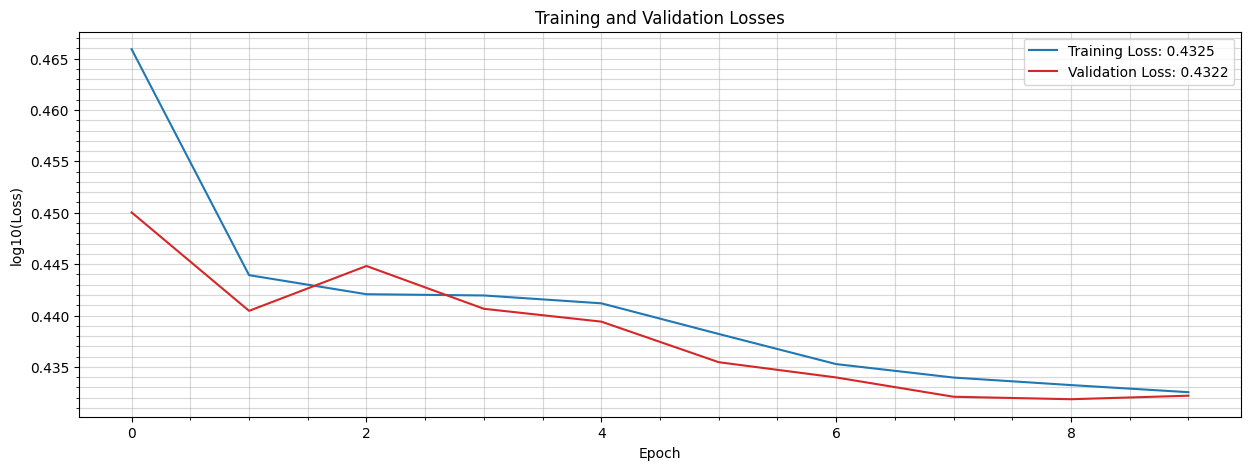

Epoch: 20/100... Training loss: 2.694358... Validation Loss: 2.694913


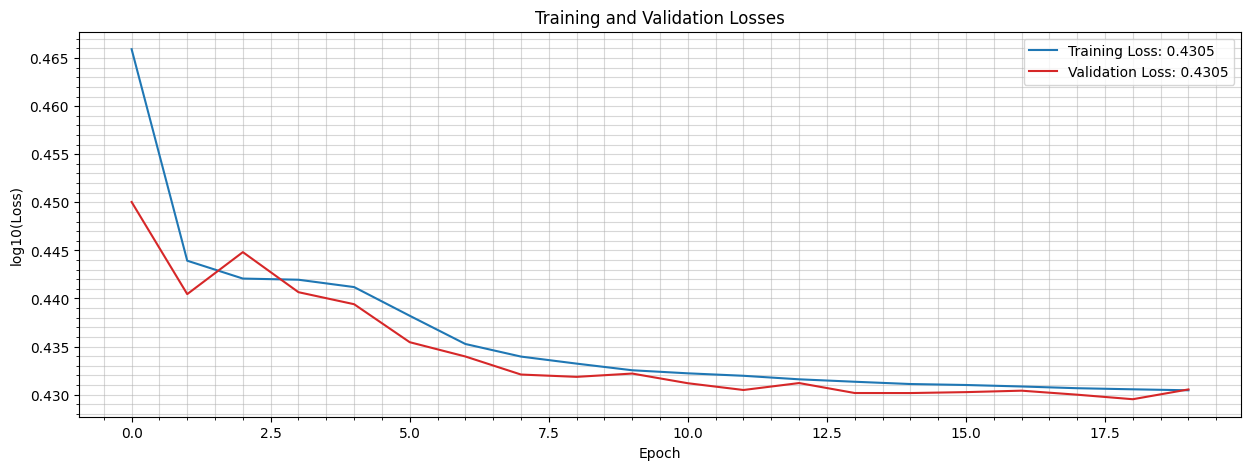

Epoch: 30/100... Training loss: 2.690265... Validation Loss: 2.691873


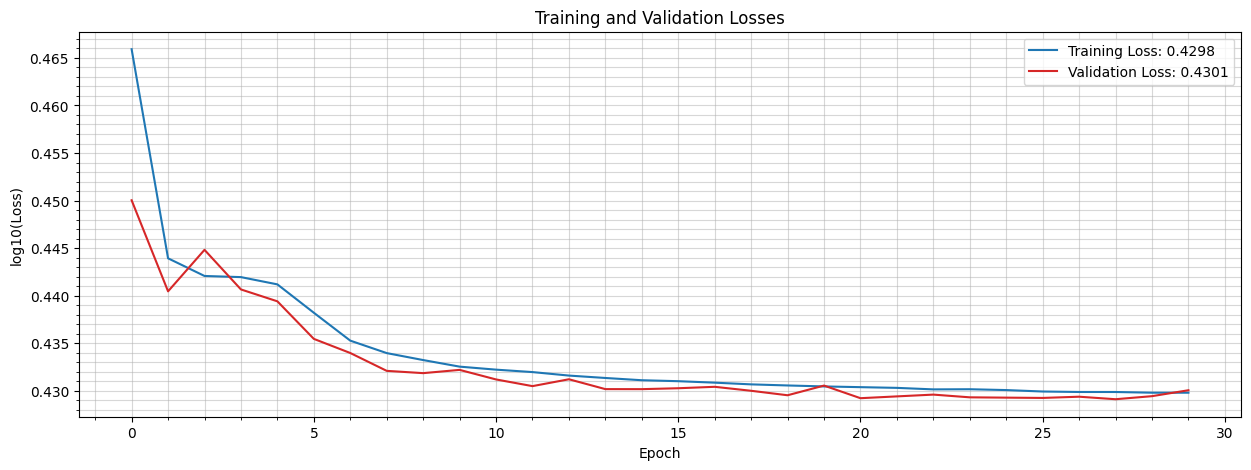

Epoch: 40/100... Training loss: 2.686947... Validation Loss: 2.690226


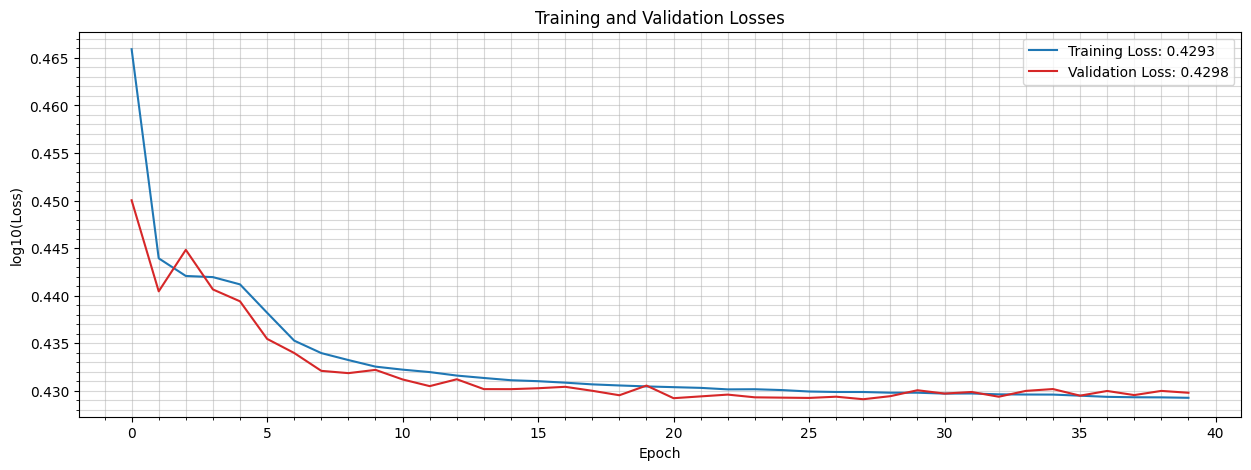

Epoch: 50/100... Training loss: 2.682824... Validation Loss: 2.695039


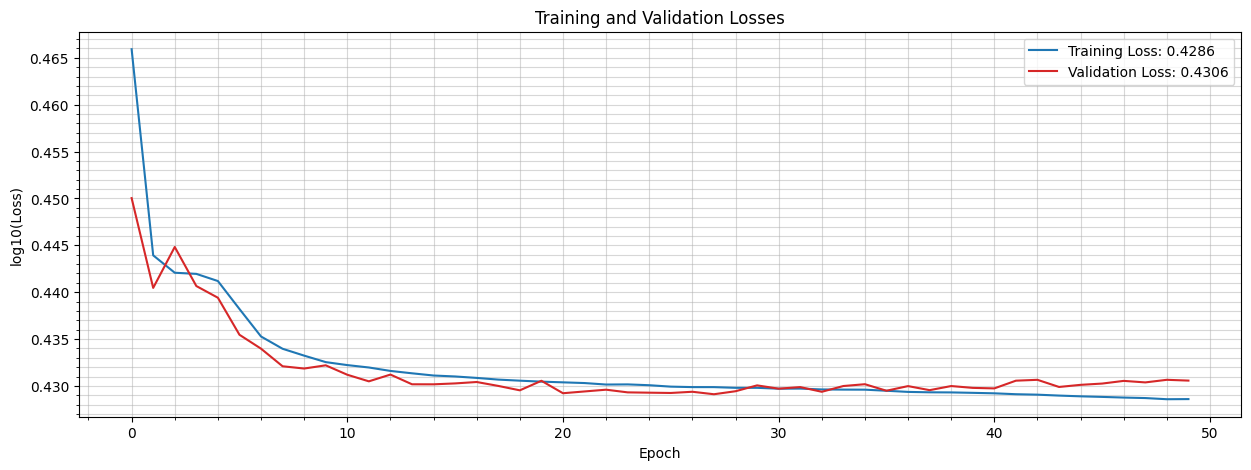

Epoch: 60/100... Training loss: 2.676597... Validation Loss: 2.701281


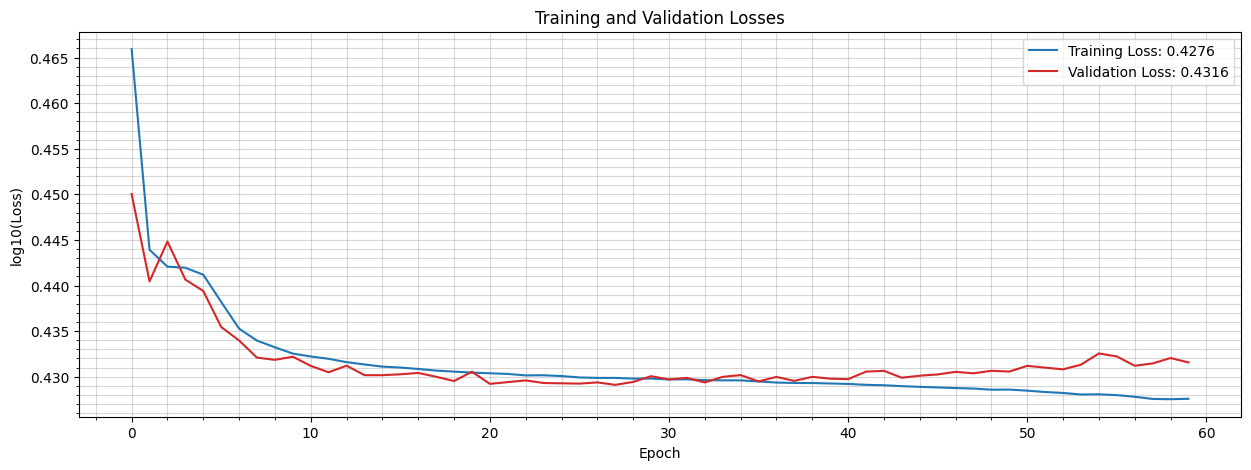

Epoch: 70/100... Training loss: 2.667444... Validation Loss: 2.711636


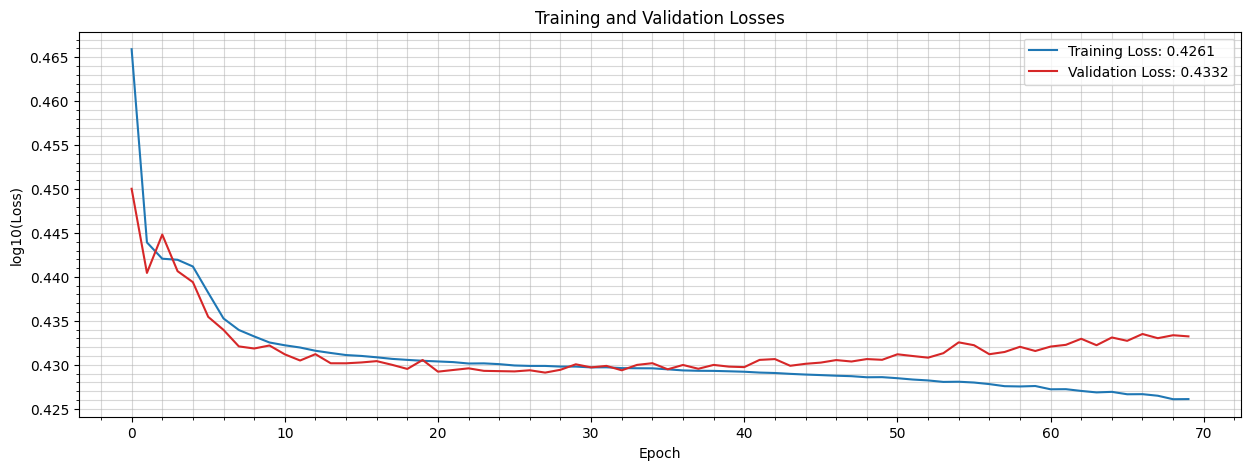

Epoch: 80/100... Training loss: 2.656559... Validation Loss: 2.719428


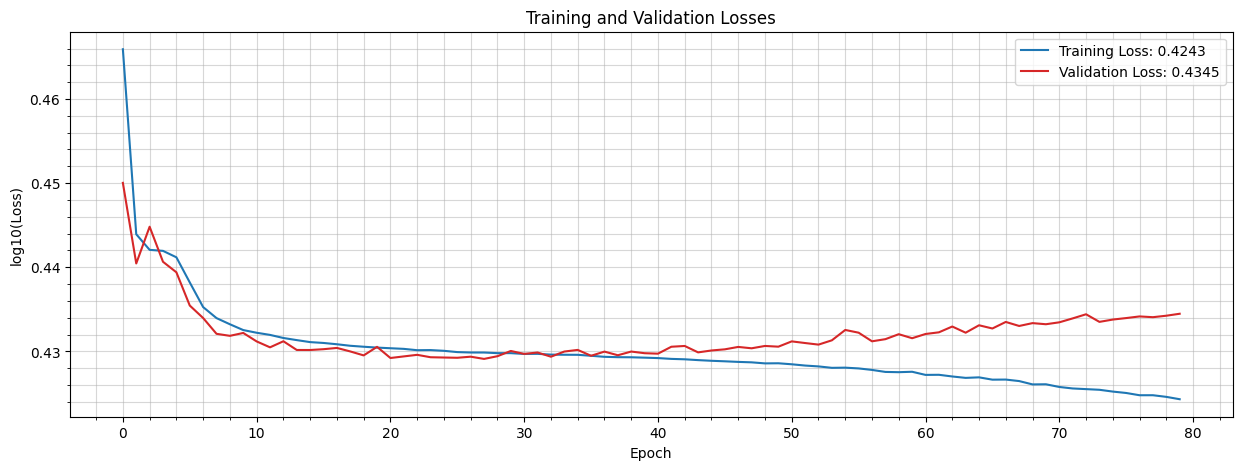

Epoch: 90/100... Training loss: 2.644324... Validation Loss: 2.731177


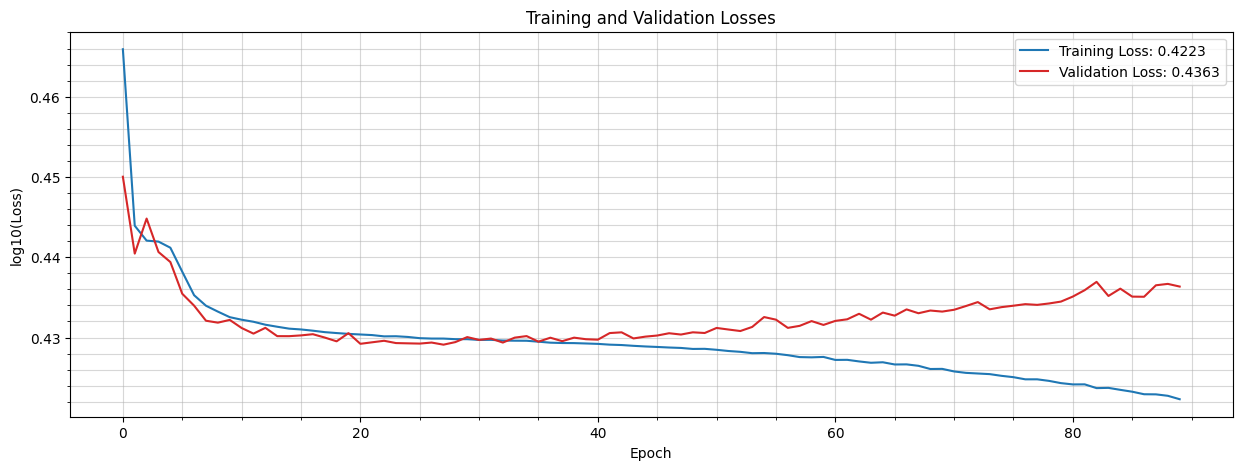

Epoch: 100/100... Training loss: 2.633929... Validation Loss: 2.743231


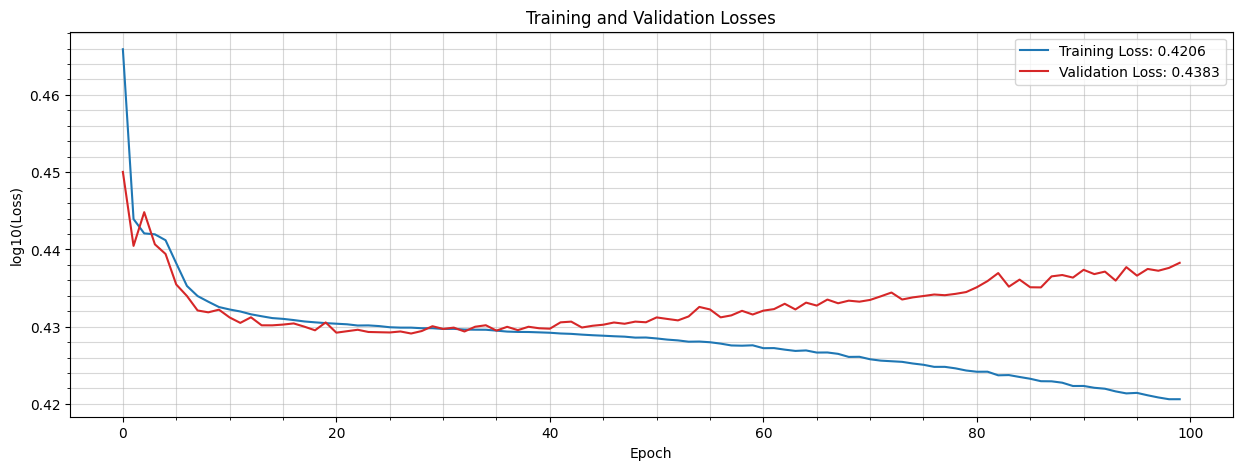

In [29]:
num_epochs = 100
val_loss_min = 1
for epoch in range(1, num_epochs + 1):

    # Training phase
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the inverse model
        inverse_outputs = inverse_net(targets)

        # Calculate loss
        loss = criterion(inverse_outputs, inputs)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    #'''
    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inverse_outputs = inverse_net(targets)
            val_loss = criterion(inverse_outputs, inputs)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch
    #'''

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {avg_train_loss:.6f}... Validation Loss: {avg_val_loss:.6f}")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")
